In [ ]:
# ---- Cell 1: restore yesterday’s workspace ----
import dill  # pip install dill if you haven’t
dill.load_session("irfa_workspace_full_v004.pkl")
print("Workspace re‑loaded. Objects now in memory:")
print(list(globals().keys())[:15], "…")

Workspace re‑loaded. Objects now in memory:
['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit'] …


,Category,Covered?,Example Series
0,Labour Market,True,"[4-Week Moving Average of Initial Claims, Regi..."
1,Income / Capacity,True,"[Compensation of Employees, Received: Wage and..."
2,Debt Service & Leverage,True,[Consumer Debt Service Payments as a Percent o...
3,Consumer Credit Quantities,True,[Consumer Loans: Credit Cards and Other Revolv...
4,Credit Performance,True,"[Delinquency Rate on Consumer Loans, All Comme..."
5,Consumer Loan Pricing,True,"[Bank Prime Loan Rate, Bank Prime Loan Rate Ch..."
6,Prices / Inflation,True,[Consumer Price Index for All Urban Consumers:...
7,Policy & Term Yields,True,[10-Year Treasury Constant Maturity Minus 2-Ye...
8,Credit Spreads / Funding Stress,True,[ICE BofA AA US Corporate Index Option-Adjuste...
9,Market Volatility & Stress,True,"[CBOE S&P 500 3-Month Volatility Index, CBOE V..."


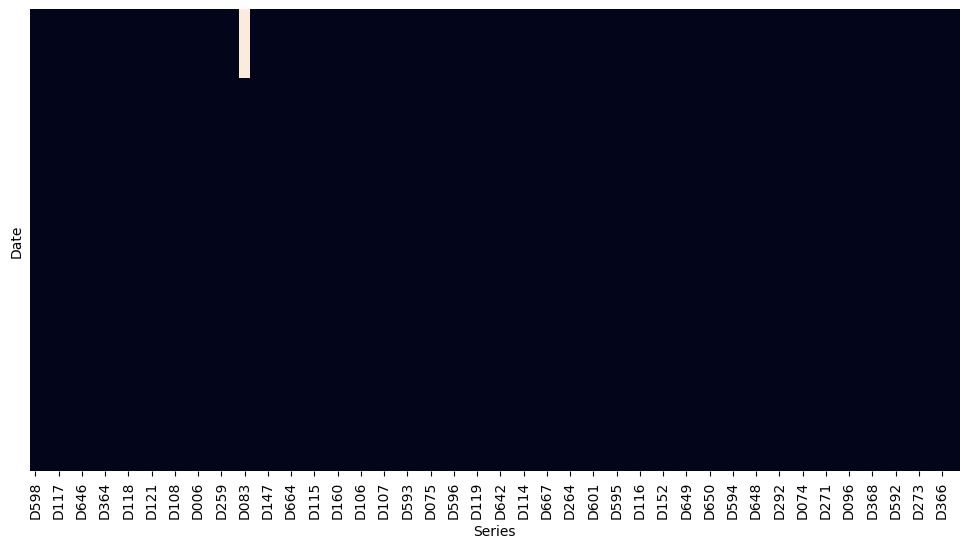

df_scaled shape : (234, 36)
df_final  shape : (233, 36)

Indicators in df_scaled:
 ['D598', 'D365', 'D117', 'D597', 'D646', 'D665', 'D364', 'D647', 'D121', 'D472', 'D108', 'D666', 'D006', 'D661', 'D259', 'D083', 'D662', 'D147', 'D664', 'D084', 'D160', 'D367', 'D075', 'D113', 'D642', 'D564', 'D649', 'D292', 'D245', 'D120', 'D110', 'D096', 'D368', 'D023', 'D100', 'D366']

Indicators in df_final:
 ['D598', 'D365', 'D117', 'D597', 'D646', 'D665', 'D364', 'D647', 'D121', 'D472', 'D108', 'D666', 'D006', 'D661', 'D259', 'D083', 'D662', 'D147', 'D664', 'D084', 'D160', 'D367', 'D075', 'D113', 'D642', 'D564', 'D649', 'D292', 'D245', 'D120', 'D110', 'D096', 'D368', 'D023', 'D100', 'D366']


In [1]:
# STEP 0: Data loading, cleaning, and imputation

import numpy as np
np.random.seed(12345)

from step0_utils import (
    load_macro_data, load_metadata, filter_metadata_by_keywords,
    subset_macro_by_ask_ids, convert_to_numeric, filter_by_date,
    plot_missing_data_heatmap, fill_missing_two_way,
    impute_after_date, prune_correlated, scale_df,
    maybe_stationarize, stationarize_df, audit_metadata_coverage
)

keywords_core = [
    # --- Labour / repayment capacity (headline only) ---
    "unemployment rate",            # keep; accept that we'll screen SA/NSA later
    "initial claims",               # UI claims

    # --- Household income ---
    "disposable personal income",
    "real disposable personal income",   # some FRED names include "Real DPI"
    
    # --- Household debt burden ratios ---
    "debt service payments",
    "financial obligations ratio",
    
    # --- Consumer credit quantity (headline + major splits) ---
    "total consumer credit",        # captures main G.19 aggregate
    "revolving consumer credit",    # credit cards
    "nonrevolving consumer credit", # auto + student loans block
    
    # --- Credit performance / loss experience ---
    "delinquency rate on consumer loans",
    "delinquency rate on credit card loans",
    "charge-off rate on credit card loans",
    "charge-off rate on consumer loans",
    
    # --- Consumer loan pricing benchmarks ---
    "interest rate on credit card plans",
    "bank prime loan rate",
    
    # --- Prices / cost of living (headline CPI + optional sub‑slice) ---
    "consumer price index for all urban consumers",  # CPI-U headline
    "cpi apparel",                      # OPTIONAL: include only if you know it is predictive
    
    # --- Policy & term structure benchmarks ---
    "federal funds rate",
    "1-year treasury constant maturity",
    "10-year treasury constant maturity",
    
    # --- Credit spreads / funding stress ---
    "aaa corporate bond yield",
    "baa corporate bond yield",
    "high yield spread",
    "ted spread",
    
    # --- Risk sentiment ---
    "vix",
    "volatility index",
    
    # --- Wealth / broad market ---
    "s&p 500",
]

labour_addons = [
    "unemployment rate - hispanic",
    "unemployment rate - white",
    "unemployment rate - black",
    "u-6 unemployment",              # broader slack
    "part-time for economic reasons",# underemployment
]

income_addons = [
    "personal saving rate",
    "wage and salary disbursements",   # common BEA phrasing
]

leverage_addons = [
    "household debt to disposable personal income",
    "household debt to gdp",
]

ccredit_addons = [
    "consumer loans at all commercial banks",
    "consumer loans owned and securitized",
    "credit cards and other revolving plans",   # alt G.19 taxonomy
]

performance_addons = [
    "net charge-offs on credit card loans",
    "net charge-offs on consumer loans",
    "delinquencies on consumer loans",  # alt phrasing
]

pricing_addons = [
    "commercial bank interest rate on personal loans",
    "finance rate on personal loans",
    "finance rate on used car loans",   # substitution channel
]

curve_addons = [
    "3-month treasury constant maturity",
    "2-year treasury constant maturity",
    "10-year treasury minus 3-month treasury",
    "10-year treasury minus 2-year treasury",
]

spread_addons = [
    "aaa corporate bond spread",
    "baa corporate bond spread",
    "option-adjusted spread",  # if you want ICE BofA indexes
]

stress_addons = [
    "financial stress index",
    "chicago fed national financial conditions index",  # nfci
]

sentiment_addons = [
    "consumer sentiment",
    "consumer expectations",
]

# choose which groups to activate
include_labour_addons      = True
include_income_addons      = True
include_leverage_addons    = True
include_ccredit_addons     = True
include_performance_addons = True
include_pricing_addons     = True
include_curve_addons       = True
include_spread_addons      = True
include_stress_addons      = True
include_sentiment_addons   = True

# build
keywords_enriched = list(keywords_core)  # start with core

if include_labour_addons:      keywords_enriched += labour_addons
if include_income_addons:      keywords_enriched += income_addons
if include_leverage_addons:    keywords_enriched += leverage_addons
if include_ccredit_addons:     keywords_enriched += ccredit_addons
if include_performance_addons: keywords_enriched += performance_addons
if include_pricing_addons:     keywords_enriched += pricing_addons
if include_curve_addons:       keywords_enriched += curve_addons
if include_spread_addons:      keywords_enriched += spread_addons
if include_stress_addons:      keywords_enriched += stress_addons
if include_sentiment_addons:   keywords_enriched += sentiment_addons

# dedupe & normalise case
keywords_enriched = sorted({kw.lower() for kw in keywords_enriched})


scale_method = "none"  # or "none","minmax","robust", "zscore"

macro = load_macro_data("no_reduction_all_macro.parquet")
meta  = load_metadata("Copy_of_macro_identifier.csv")

category_keywords = {
    # Labour slack & repayment capacity
    "Labour Market": [
        "unemployment rate",
        "unemployment rate - hispanic",
        "unemployment rate - white",
        "unemployment rate - black",
        "initial claims",
        "u-6 unemployment",
        "part-time for economic reasons",
    ],

    # Disposable cash-flow buffer
    "Income / Capacity": [
        "disposable personal income",
        "real disposable personal income",
        "personal saving rate",
        "wage and salary disbursements",
    ],

    # Household leverage & servicing
    "Debt Service & Leverage": [
        "debt service payments",
        "financial obligations ratio",
        "household debt to disposable personal income",
        "household debt to gdp",
    ],

    # Consumer credit quantities
    "Consumer Credit Quantities": [
        "total consumer credit",
        "revolving consumer credit",
        "nonrevolving consumer credit",
        "consumer loans at all commercial banks",
        "consumer loans owned and securitized",
        "credit cards and other revolving plans",
    ],

    # Credit performance
    "Credit Performance": [
        "delinquency rate on consumer loans",
        "delinquency rate on credit card loans",
        "delinquencies on consumer loans",
        "net charge-offs on credit card loans",
        "net charge-offs on consumer loans",
        "charge-off rate on credit card loans",
        "charge-off rate on consumer loans",
    ],

    # Loan pricing benchmarks
    "Consumer Loan Pricing": [
        "interest rate on credit card plans",
        "commercial bank interest rate on personal loans",
        "finance rate on personal loans",
        "finance rate on used car loans",
        "bank prime loan rate",
    ],

    # Inflation background
    "Prices / Inflation": [
        "consumer price index for all urban consumers",
        "cpi apparel",
    ],

    # Policy & rates structure
    "Policy & Term Yields": [
        "federal funds rate",
        "1-year treasury constant maturity",
        "2-year treasury constant maturity",
        "3-month treasury constant maturity",
        "10-year treasury constant maturity",
        "10-year treasury minus 3-month treasury",
        "10-year treasury minus 2-year treasury",
    ],

    # Credit spreads & funding stress
    "Credit Spreads / Funding Stress": [
        "aaa corporate bond yield",
        "aaa corporate bond spread",
        "baa corporate bond yield",
        "baa corporate bond spread",
        "high yield spread",
        "ted spread",
        "option-adjusted spread",
    ],

    # Market stress / volatility
    "Market Volatility & Stress": [
        "vix",
        "volatility index",
        "financial stress index",
        "chicago fed national financial conditions index",
    ],

    # Wealth / sentiment
    "Equity & Confidence": [
        "s&p 500",
        "consumer sentiment",
        "consumer expectations",
    ],
}

# Audit the entire metadata
coverage_df = audit_metadata_coverage(meta, category_keywords)
display(coverage_df)


real_estate_meta = filter_metadata_by_keywords(meta, keywords_core)
# Filter for non-U.S. series to exclude
exclude_countries = (
    r'Canada|Mexico|Brazil|China|India|Japan|Korea|South Korea|Russia|Euro|'
    r'United Kingdom|U\.K\.|UK|Britain|Great Britain|England|Scotland|Wales|'
    r'Euro Area|Eurozone|European Union|Germany|France|Italy|Spain|Portugal|Greece|'
    r'Netherlands|Belgium|Austria|Ireland|Finland|Sweden|Norway|Denmark|Switzerland|'
    r'Australia|New Zealand|Hong Kong|Singapore|Taiwan|South Africa|Israel|Argentina|Chile'
)
real_estate_meta_us = real_estate_meta[~real_estate_meta['series_name']
                                       .str.contains(exclude_countries)]

df0 = subset_macro_by_ask_ids(macro, real_estate_meta_us.ask_id)
df1 = convert_to_numeric(df0)
df2 = filter_by_date(df1, "2005-01-01")
plot_missing_data_heatmap(df2, figsize=(12,6), cmap="viridis")
df3 = fill_missing_two_way(df2)
df4, dropped = prune_correlated(df3, threshold=0.90)
df_scaled, scaler = scale_df(df4, method=scale_method)
df_final = stationarize_df(df_scaled, meta.set_index("ask_id").action.to_dict())

# print shapes
print("df_scaled shape :", df_scaled.shape)
print("df_final  shape :", df_final.shape)

# list which series survived into each stage
print("\nIndicators in df_scaled:\n", df_scaled.columns.tolist())
print("\nIndicators in df_final:\n",  df_final.columns.tolist())

In [2]:
import pandas as pd

# ─── Avoid truncation ───────────────────────────────────────────────────────
pd.set_option('display.max_rows',    None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width',       None)
pd.set_option('display.max_colwidth',None)

# ─── Category Mapping ───────────────────────────────────────────────────────
category_keywords = {
    # Household repayment capacity / labour slack
    "Labour Market": [
        "unemployment rate",
        "initial claims",
    ],

    # Income buffer
    "Income / Capacity": [
        "disposable personal income",
        "real disposable personal income",  # alt naming
    ],

    # Debt servicing burden
    "Debt Service": [
        "debt service payments",
        "financial obligations ratio",
    ],

    # Consumer credit quantities (G.19 headline + splits)
    "Consumer Credit Quantities": [
        "total consumer credit",
        "revolving consumer credit",
        "nonrevolving consumer credit",
    ],

    # Loan performance / losses
    "Credit Performance": [
        "delinquency rate on consumer loans",
        "delinquency rate on credit card loans",
        "charge-off rate on credit card loans",
        "charge-off rate on consumer loans",
    ],

    # Pricing benchmarks faced by households
    "Consumer Loan Pricing": [
        "interest rate on credit card plans",
        "bank prime loan rate",
    ],

    # Inflation backdrop (headline CPI + optional sub-slice)
    "Prices / Inflation": [
        "consumer price index for all urban consumers",
        "cpi apparel",  # <-- remove if you ultimately prefer headline-only
    ],

    # Policy & term structure anchors
    "Policy & Term Yields": [
        "federal funds rate",
        "1-year treasury constant maturity",
        "10-year treasury constant maturity",
    ],

    # Credit risk / funding stress
    "Credit Spreads": [
        "aaa corporate bond yield",
        "baa corporate bond yield",
        "high yield spread",
        "ted spread",
    ],

    # Market risk appetite / volatility
    "Market Volatility": [
        "vix",
        "volatility index",
    ],

    # Wealth / broad risk sentiment
    "Equity Market": [
        "s&p 500",
    ],
}

def assign_category(name: str) -> str:
    for cat, keys in category_keywords.items():
        for key in keys:
            if key.lower() in name.lower():
                return cat
    return "Other"

# ─── 1) Build Macro‑Indicator Catalogue (Table 1) ────────────────────────────
# Align meta to df_final.columns exactly (and in order)
meta_indexed = meta.set_index('ask_id', verify_integrity=True)  # ensure no duplicates
retained_ids = list(df_final.columns)                         # 43 codes, in order
meta_final   = meta_indexed.loc[retained_ids].reset_index()

# Assign categories
meta_final['Category'] = meta_final['series_name'].apply(assign_category)

# Rename and select only the columns you need
catalogue = (
    meta_final.loc[:, ['ask_id','fed_id','series_name','action','inception_date','Category']]
              .rename(columns={
                  'ask_id':        'Code',
                  'fed_id':        'Mnemonic',
                  'series_name':   'Description',
                  'action':        'Transformation',
                  'inception_date':'Start Date'
              })
)

print("\n=== Table 1: Macro‑Indicator Catalogue ===\n")
print(catalogue.to_string(index=False))


# ─── 2) Produce Summary Statistics (Table 2) ─────────────────────────────────
stats = (
    df_final
      .describe()
      .transpose()[['count','mean','std','min','max']]
      .rename(columns={
          'count':'N',
          'mean':'Mean',
          'std':'SD',
          'min':'Min',
          'max':'Max'
      })
      .round(3)
)

print("\n=== Table 2: Summary Statistics for Macro Panel ===\n")
print(stats.to_string())


=== Table 1: Macro‑Indicator Catalogue ===

Code          Mnemonic                                                                                                Description Transformation Start Date                   Category
D598       LNS14000003                                                                                  Unemployment Rate - White           none 1954-01-01              Labour Market
D365           AAA10YM          Moody's Seasoned Aaa Corporate Bond Yield Relative to Yield on 10-Year Treasury Constant Maturity           none 1953-04-01       Policy & Term Yields
D117    CUUR0000SETA01                        Consumer Price Index for All Urban Consumers: New Vehicles in U.S. City Average NSA            pct 1947-03-01         Prices / Inflation
D597       LNS14000009                                                                     Unemployment Rate - Hispanic or Latino           diff 1973-03-01              Labour Market
D646             CPFFM                  

✅ First 7 PCs explain 82.86%


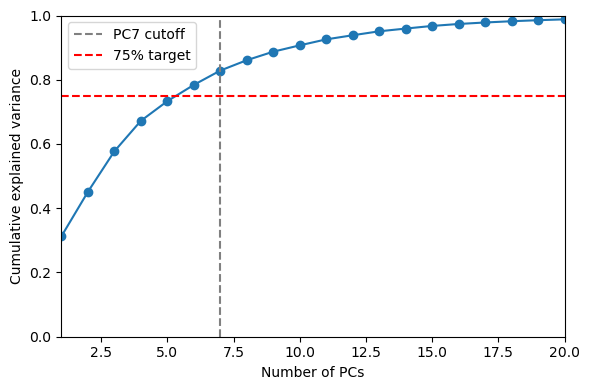

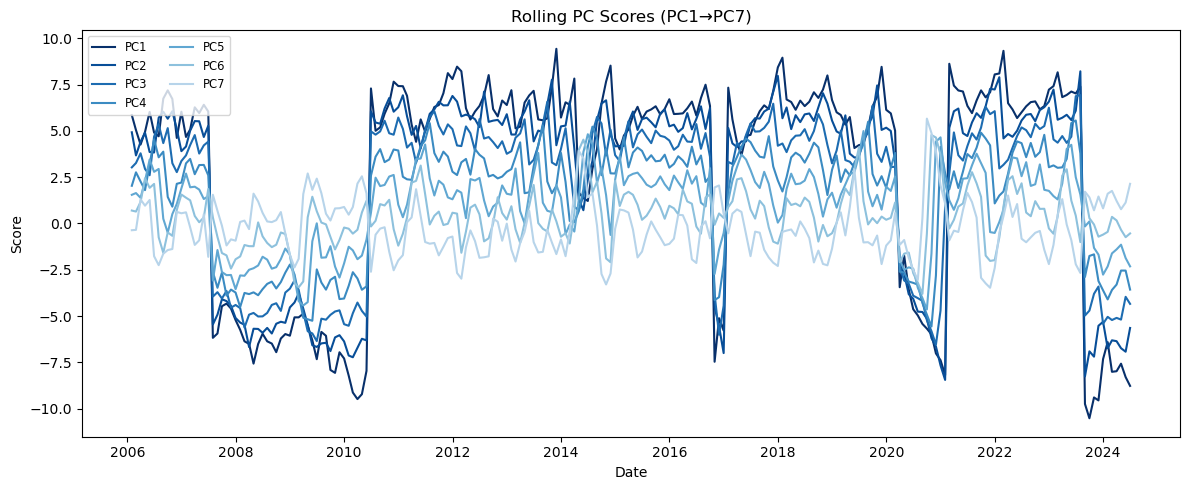

Top 8 indicators by avg(|loading|):
   Indicator  AvgAbsLoading
19      D084       0.173114
33      D023       0.163845
3       D597       0.157894
7       D647       0.157675
4       D646       0.151192
9       D472       0.150398
30      D110       0.150318
1       D365       0.147365 

→ Selected indicators for regime detection: ['D084', 'D023', 'D597', 'D647', 'D646', 'D472', 'D110', 'D365'] 

# D084,VIXCLS,"CBOE Volatility Index: VIX",Daily,1990-01-02,Index,pct
# D023,IC4WSA,"4-Week Moving Average of Initial Claims",Weekly,1967-01-28,Number,pct
# D597,LNS14000009,"Unemployment Rate - Hispanic or Latino",Monthly,1973-03-01,Percent,diff
# D647,TB3SMFFM,"3-Month Treasury Bill Minus Federal Funds Rate",Monthly,1954-07-01,Percent,none
# D646,CPFFM,"3-Month Commercial Paper Minus Federal Funds Rate",Monthly,1997-01-01,Percent,none
# D472,A229RX0,"Real Disposable Personal Income: Per Capita",Monthly,1959-01-01,Chained 2012 Dollars,pct
# D110,CPIAPPSL,"Consumer Price Index for All Urban C

In [3]:
# ──────────────────────────────────────────────────────────────────────────────
# STEP 1: Rolling R2‑PCA & Top‑8 Indicator Selection
# ──────────────────────────────────────────────────────────────────────────────

import numpy as np

from r2pca_utils import (
    compute_full_pca,
    determine_K,
    plot_scree,
    rolling_r2pca,
    plot_rolling_scores,
    select_top_indicators,
    print_meta_info,
    compute_loading_share,
)

# 0) prereqs: df_scaled, meta_df

# 1) full‐sample PCA → scree & pick PC1…PC7
ratios, _ = compute_full_pca(df_scaled, pct_variance=0.75)
K = determine_K(ratios, pct_threshold=0.75, fixed_K=7)
plot_scree(ratios, K)

# 2) rolling‐window PCA
pc_ts, loadings_all, eig_cumvar, r2pca_r2, last_model = rolling_r2pca(df_scaled, K=K, window_size=12)
plot_rolling_scores(pc_ts)

# 3) compute avg|loading| and show top 8
loading_df = select_top_indicators(
    loadings_all,
    feature_names=list(df_scaled.columns),
    top_N=8
)
print("Top 8 indicators by avg(|loading|):")
print(loading_df.head(8), "\n")

# 4) pick the top 8 and print metadata comments
selected = loading_df["Indicator"].iloc[:8].tolist()
print("→ Selected indicators for regime detection:", selected, "\n")
print_meta_info(selected, meta)

# 5) loading‐mass share
share = compute_loading_share(loading_df, top_n=8)
print(f"\nTop 8 account for {share:.2%} of the total loading mass")

# 6) R2PCA cum. variance 
eig = np.array(eig_cumvar)
r2  = np.array(r2pca_r2)

print("Plain‐PCA cumvar (min, mean, max):",
      f"{eig.min():.3f}, {eig.mean():.3f}, {eig.max():.3f}")
print("R2‑PCA recon R² (min, mean, max):",
      f"{r2.min():.3f}, {r2.mean():.3f}, {r2.max():.3f}")

# Alias for Step 2  
selected_indicators = selected

In [ ]:
# Based on the approach one could also run a normal PCA on a monthly basis and determine for each month the absolut avg. factor loadings. Then
# they could be added together per factor to see whether they change drastically (If interesting in current study set up). 
# Also the factor loadings of the discovered 8 top indicators could be shown across time for enhanced visualisation. 
# In addition maybe also show the cumulative variance of the R2PCA model.    

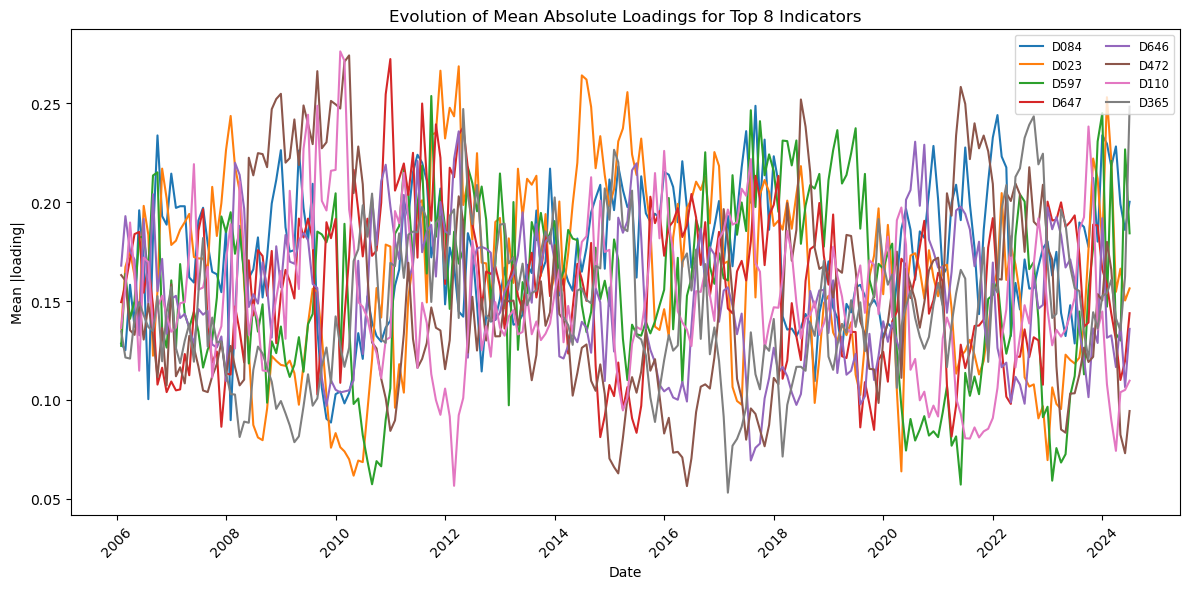

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# assuming `df_scaled`, `pc_ts`, `loadings_all`, and `selected_indicators` are already defined
feature_names = list(df_scaled.columns)
L = np.stack(loadings_all)      # shape (T, K, M)
dates = pc_ts.index

# build a DataFrame of mean |loading| per indicator over windows
df_loadings = pd.DataFrame({
    ind: np.mean(np.abs(L[:, :, feature_names.index(ind)]), axis=1)
    for ind in selected_indicators
}, index=dates)

# plot all series together
plt.figure(figsize=(12, 6))
for ind in df_loadings.columns:
    plt.plot(df_loadings.index, df_loadings[ind], label=ind, linewidth=1.5)

plt.xlabel("Date")
plt.ylabel("Mean |loading|")
plt.title("Evolution of Mean Absolute Loadings for Top 8 Indicators")
plt.legend(loc="upper right", fontsize="small", ncol=2)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

[Step 2] regime data shape = (205, 8)


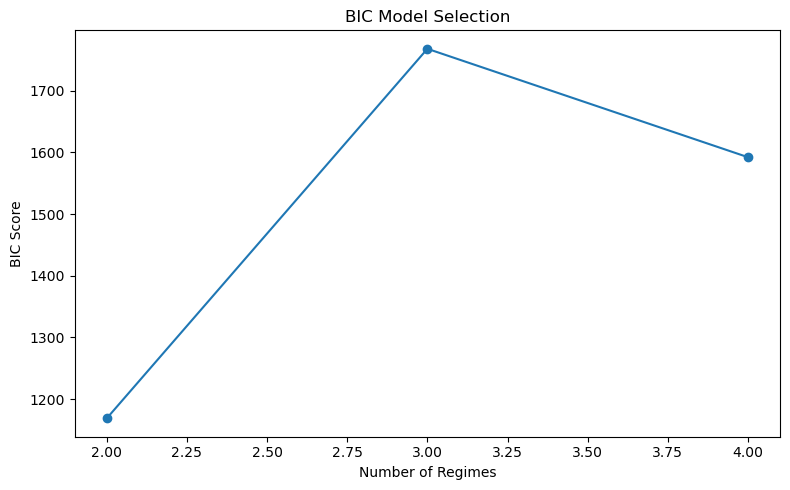

→ selected number of regimes K = 2


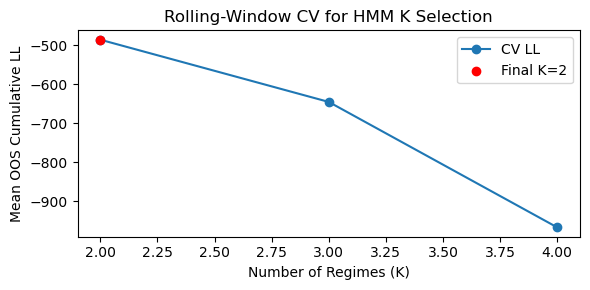

→ Final number of regimes K = 2


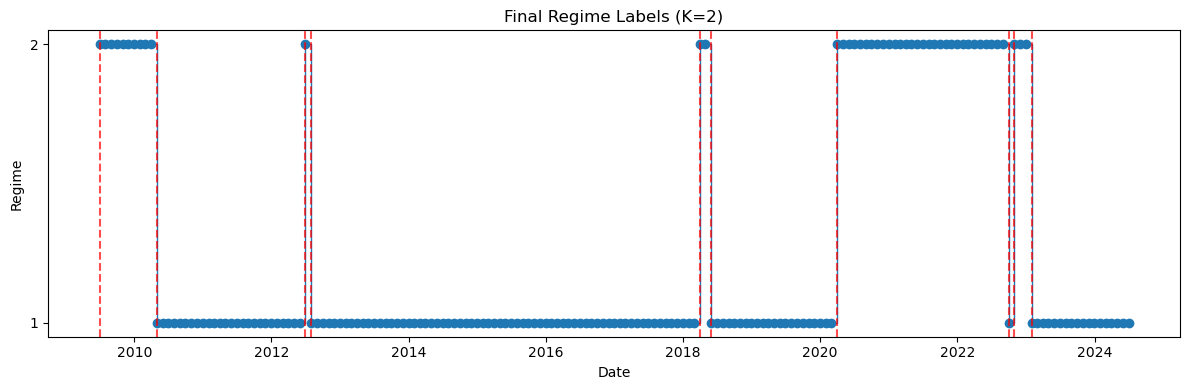

Regime change dates: [Timestamp('2009-06-30 00:00:00'), Timestamp('2010-04-30 00:00:00'), Timestamp('2012-06-30 00:00:00'), Timestamp('2012-07-31 00:00:00'), Timestamp('2018-03-31 00:00:00'), Timestamp('2018-05-31 00:00:00'), Timestamp('2020-03-31 00:00:00'), Timestamp('2022-09-30 00:00:00'), Timestamp('2022-10-31 00:00:00'), Timestamp('2023-01-31 00:00:00')]


In [6]:
# ──────────────────────────────────────────────────────────────────────────────
# STEP 2: Regime Detection via HMM (automated)
# ──────────────────────────────────────────────────────────────────────────────

from r2rd_utils import (
    prepare_regime_data,
    compute_bic_scores,
    select_best_k,
    plot_bic_scores,
    warm_start_hmm,
    get_regime_change_dates,
    plot_regime_labels,
    rolling_oos_ll,
    compute_cv_scores, 
    select_best_k_cv, 
    select_best_k_combined, 
    plot_cv_scores
)

# ── Prereqs from Step 1 ────────────────────────────────────────────────────────
#   df_final           : cleaned & (optionally) scaled macro DataFrame
#   selected_indicators: list[str] of your 8 ask_ids

# 0) Truncate to match your loan‐data span (2007-06-01)
df_final_trunc = df_final[df_final.index >= "2007-06-01"]


# 1) Build & scale the regime dataset
df_scaled_regime, regime_scaler = prepare_regime_data(
    df_final_trunc,
    selected_indicators,
    impute_date='2007-06-01',
    scale_method='none'
)
print(f"[Step 2] regime data shape = {df_scaled_regime.shape}")

# 2) BIC‑based model selection on training slice
bic_scores = compute_bic_scores(
    df_scaled_regime,
    train_end='2010-05-31',
    k_min=2,
    k_max=4
)
plot_bic_scores(bic_scores)

best_k = select_best_k(bic_scores)
print(f"→ selected number of regimes K = {best_k}")

# 3) Rolling‑window CV & combine with BIC
# Rolling‑window CV (annual test, quarterly folds) & combine with BIC

cv_scores = compute_cv_scores(
    df_scaled_regime,
    k_min=2,
    k_max=4,
    initial_train='2010-05-31',
    test_horizon=12,   # 12‑month or 24 month test window
    step=3             # slide forward every 3 months
)

best_k_cv    = select_best_k_cv(cv_scores)
best_k_final = select_best_k_combined(best_k, best_k_cv, cv_scores)
plot_cv_scores(cv_scores, best_k_final)

best_k = best_k_final
print(f"→ Final number of regimes K = {best_k}")

# 4) Final regime detection via warm‑start HMM
df_probs, final_model = warm_start_hmm(
    df_scaled_regime,
    K=best_k,
    start_length=24
)

# 5) Plot the decoded regimes with change‑date markers
plot_regime_labels(df_probs, K=best_k)

# 6) List the regime‑change dates
change_dates = get_regime_change_dates(df_probs)
print("Regime change dates:", change_dates.tolist())


In [7]:
# Inspect final_model so we can find where the transition matrix lives
print("final_model class:", final_model.__class__)
print("Attributes on final_model:")
for attr in dir(final_model):
    if not attr.startswith('_'):
        print(" ", attr)


final_model class: <class 'models.HMMs.r2_gaussian_hmm.R2GaussianHMM'>
Attributes on final_model:
  assign_labels
  base_dump
  base_load
  cluster_model
  covariance_type
  current_regime_index_remap
  current_transition
  dump
  fit
  fit_transform
  get_cost_matrix
  get_model_regimes
  load
  model
  n_components
  n_iter
  optimal_number_of_state
  pair_assignment_cost
  predict
  prev_regimes
  prev_transmat_
  process_data_input
  scaler
  start_prob
  tol
  transform


In [8]:
import numpy as np
import pandas as pd

# ─── Table 5: IC & out‑of‑sample CV log‑likelihood for K=2–4 ────────────────
train_end = '2010-05-31'
N = df_scaled_regime.loc[:train_end].shape[0]
d = df_scaled_regime.shape[1]

rows = []
for k in [2, 3, 4]:
    # extract BIC
    bic = bic_scores[k] if isinstance(bic_scores, dict) else bic_scores.loc[bic_scores['K']==k,'BIC'].iat[0]
    # extract CV log‑likelihood
    if isinstance(cv_scores, dict):
        vals = cv_scores[k]
        cvll = np.mean(vals) if hasattr(vals, '__iter__') else vals
    else:
        cvll = cv_scores.loc[cv_scores['K']==k,'CV_LL'].mean()
    # parameter count and invert BIC
    p_k = (k-1) + k*(k-1) + 2*k*d
    ll  = (-bic + p_k*np.log(N)) / 2
    aic = -2*ll + 2*p_k
    rows.append({'K':k, 'BIC':bic, 'AIC':aic, 'CV_LL':cvll})

table5 = pd.DataFrame(rows)
print(table5.to_latex(index=False,
    caption="Information criteria and out-of-sample CV log\\,-likelihood for $K=2\\text{--}4$",
    label="tab:ic_cv"
))


# ─── Table 6: HMM Transition Matrix ─────────────────────────────────────────
# locate transition matrix inside final_model
if hasattr(final_model.model, 'transmat_'):
    P = final_model.model.transmat_
elif hasattr(final_model, 'prev_transmat_'):
    P = final_model.prev_transmat_
elif hasattr(final_model, 'current_transition'):
    P = np.array(final_model.current_transition)
else:
    raise AttributeError("Cannot locate transition matrix")

n = P.shape[0]
tm = pd.DataFrame(
    P,
    index=[f"From Regime {i}" for i in range(1, n+1)],
    columns=[f"To Regime {j}"   for j in range(1, n+1)]
)
print(tm.to_latex(
    caption="Estimated transition probabilities of the two‑state HMM.",
    label="tab:transmat"
))


# ─── Table 7: Conditional Means & Variances by Regime ───────────────────────
means = pd.DataFrame(
    final_model.model.means_,
    columns=selected_indicators,
    index=[f"Regime {i}" for i in range(1, n+1)]
)
vars_ = pd.DataFrame(
    [np.diag(cov) for cov in final_model.model.covars_],
    columns=selected_indicators,
    index=means.index
)
table7 = pd.concat([
    means.add_prefix('Mean_'),
    vars_.add_prefix('Var_')
], axis=1)
print(table7.to_latex(
    caption="Conditional means and variances of selected indicators by regime.",
    label="tab:state_stats"
))

\begin{table}
\caption{Information criteria and out-of-sample CV log\,-likelihood for $K=2\text{--}4$}
\label{tab:ic_cv}
\begin{tabular}{rrrr}
\toprule
K & BIC & AIC & CV_LL \\
\midrule
2 & 1168.925138 & 1113.501975 & -485.526329 \\
3 & 1767.883463 & 1679.206403 & -645.382614 \\
4 & 1592.169050 & 1467.071054 & -967.573706 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}
\caption{Estimated transition probabilities of the two‑state HMM.}
\label{tab:transmat}
\begin{tabular}{lrr}
\toprule
 & To Regime 1 & To Regime 2 \\
\midrule
From Regime 1 & 0.985663 & 0.014337 \\
From Regime 2 & 0.031095 & 0.968905 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}
\caption{Conditional means and variances of selected indicators by regime.}
\label{tab:state_stats}
\begin{tabular}{lrrrrrrrrrrrrrrrr}
\toprule
 & Mean_D084 & Mean_D023 & Mean_D597 & Mean_D647 & Mean_D646 & Mean_D472 & Mean_D110 & Mean_D365 & Var_D084 & Var_D023 & Var_D597 & Var_D647 & Var_D646 & Var_D472 & Var_D110 & Var_D365 \

▶︎ State‑specific Means:


,D084,D023,D597,D647,D646,D472,D110,D365
Regime 1,-0.264600,-0.184855,-0.212203,-0.02923,-0.268706,0.098803,-0.010340,-0.018739
Regime 2,0.577992,0.403798,0.463536,0.06385,0.586961,-0.215825,0.022586,0.040933



▶︎ State‑specific Variances:


,D084,D023,D597,D647,D646,D472,D110,D365
Regime 1,0.484993,0.001737,0.063374,0.207719,0.206118,0.190928,0.496445,0.514176
Regime 2,1.638282,2.943221,2.733050,2.725027,2.232224,2.699745,2.099533,2.059102


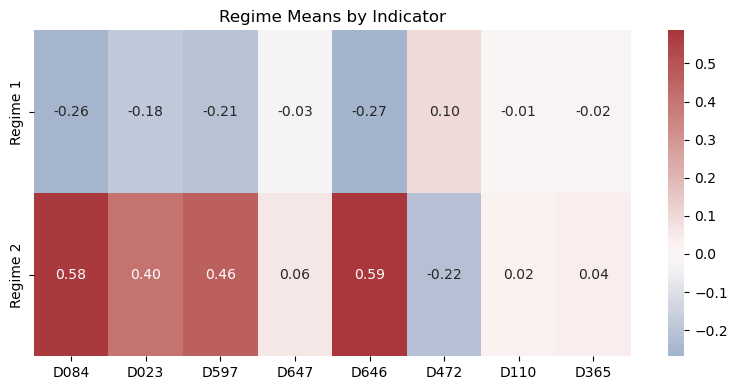

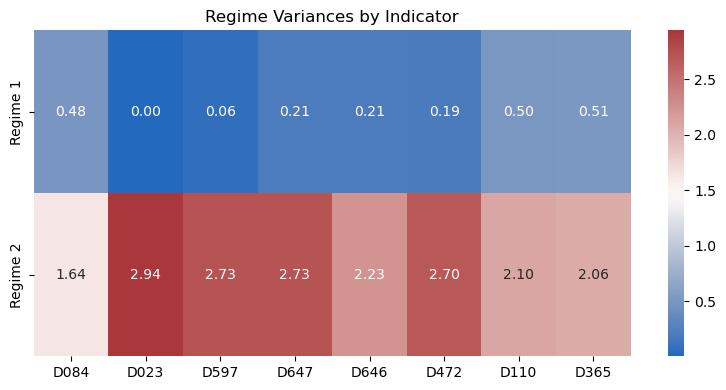

In [9]:
# STEP 3.1: State‐specific Means & Variances
# ─────────────────────────────────────────────
from xaiR2_utils import (
    compute_state_stats,
    display_state_stats,
    plot_state_heatmaps
)

# Extract
means_df, vars_df = compute_state_stats(final_model, selected_indicators)

# Display & plot
display_state_stats(means_df, vars_df)
plot_state_heatmaps(means_df, vars_df)

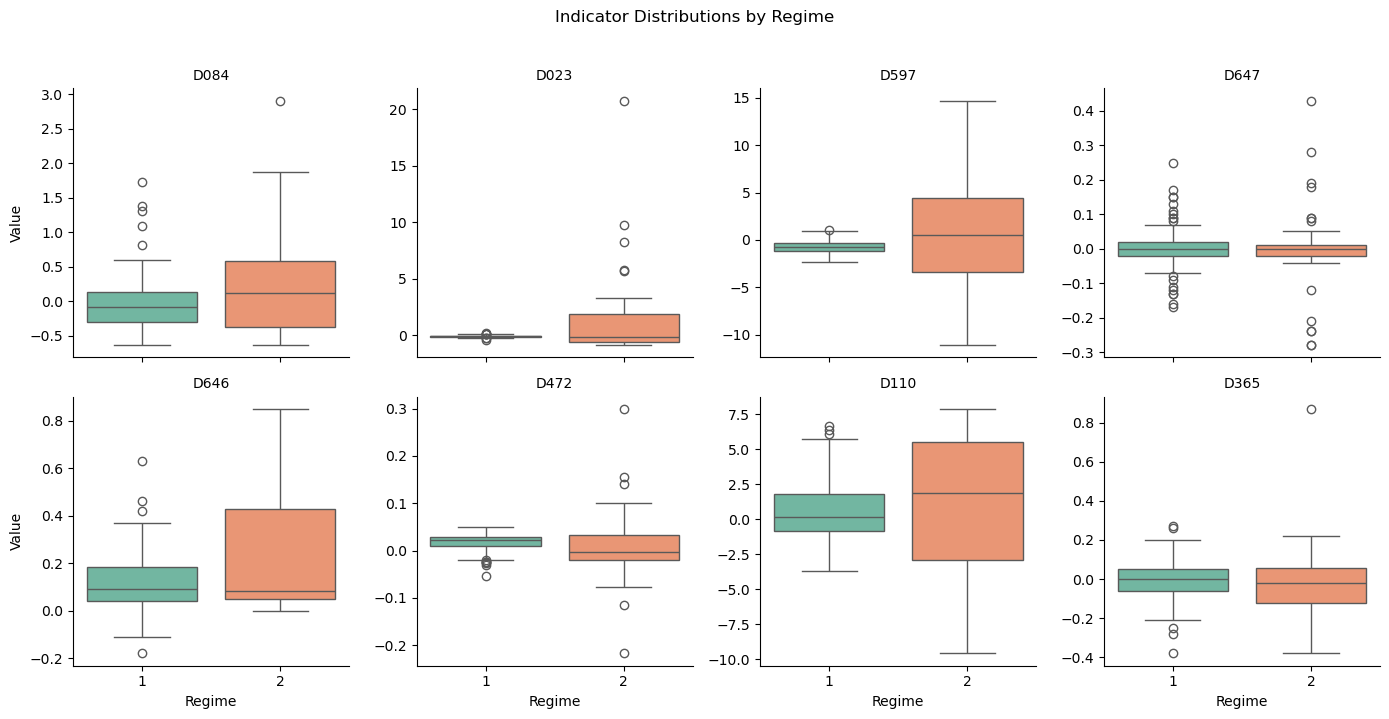

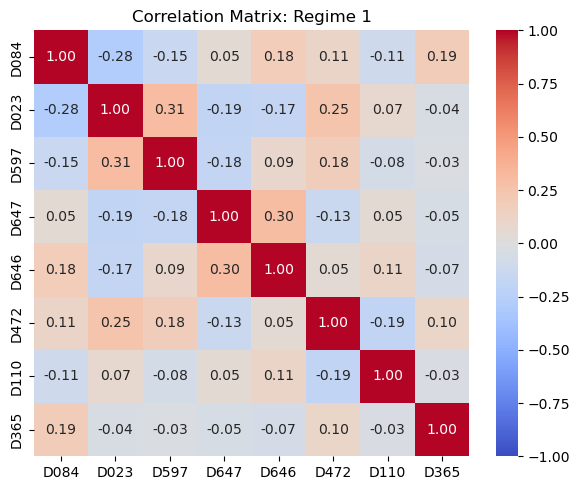

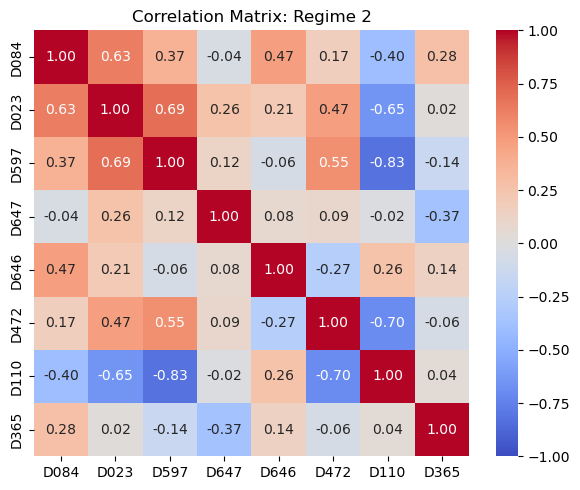

Regime 1 share: 74.59%
Regime 2 share: 25.41%


In [10]:
# STEP 3.2: Visual Profiling of Indicators by Regime
# ────────────────────────────────────────────────────
from xaiR2_utils import profile_indicators_by_regime
from step0_utils import impute_after_date

# 1) Subset df_final to just the 8 selected indicator series
df_reduced = df_final[selected_indicators].copy()

# 2) Linearly interpolate any gaps after start date
df_reduced_imputed = impute_after_date(df_reduced, start_date='2005-01-01')

profile_indicators_by_regime(
    df_reduced_imputed,
    df_probs,
    selected_indicators
)


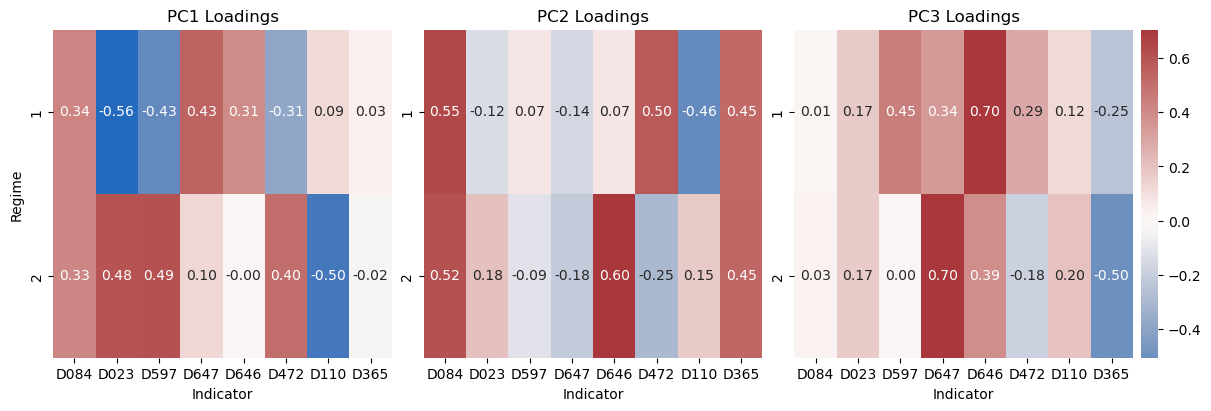

In [11]:
# STEP 3.3: PCA Deep‐Dive → PC1–PC3 Loadings
# ─────────────────────────────────────────────
from xaiR2_utils import compute_pc_deep_dive, plot_pc_deep_dive

# Recompute loadings
loadings_3pc, pc_loadings = compute_pc_deep_dive(
    df_scaled_regime,
    df_probs,
    selected_indicators
)

# Plot heatmaps
plot_pc_deep_dive(pc_loadings)


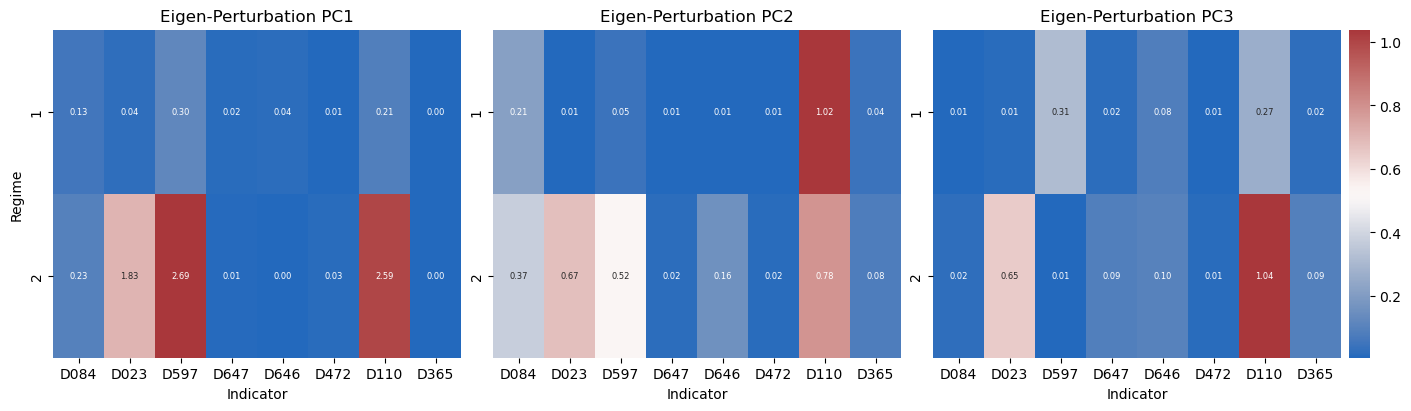

In [12]:
# STEP 3.4: Eigen‐Perturbation Sensitivity
# ────────────────────────────────────────────
from xaiR2_utils import compute_sensitivity_dfs, plot_sensitivity_dfs

# Compute sensitivity dataframes
_, sensitivity_dfs = compute_sensitivity_dfs(
    loadings_3pc,
    df_scaled_regime,
    df_probs,
    selected_indicators
)

# Plot sensitivity heatmaps
plot_sensitivity_dfs(sensitivity_dfs)


Vuong Test (per-sample): V = -6.065, p-value = 0.000

Model               LL     p       AIC       BIC
1-state        -471.10    16    974.21    999.54
2-state        -521.75    35   1113.50   1168.93


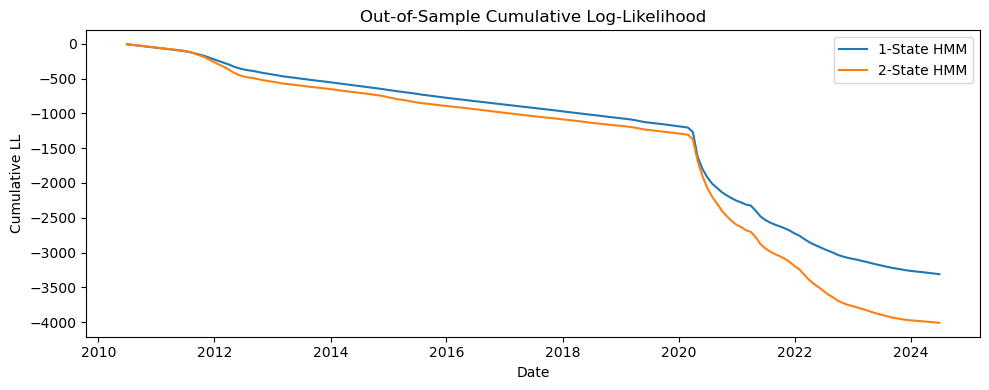

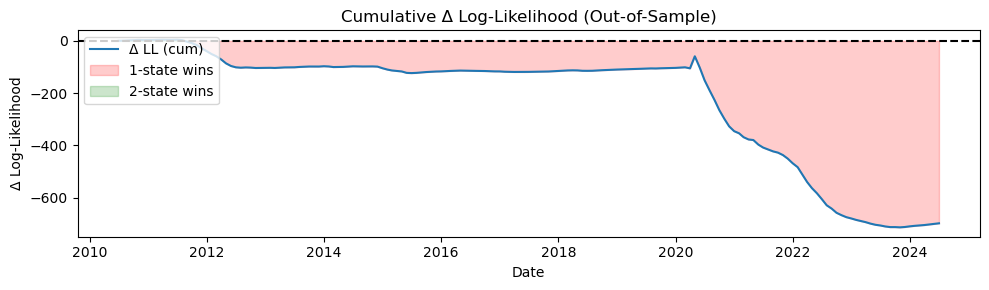

<Figure size 1200x300 with 0 Axes>

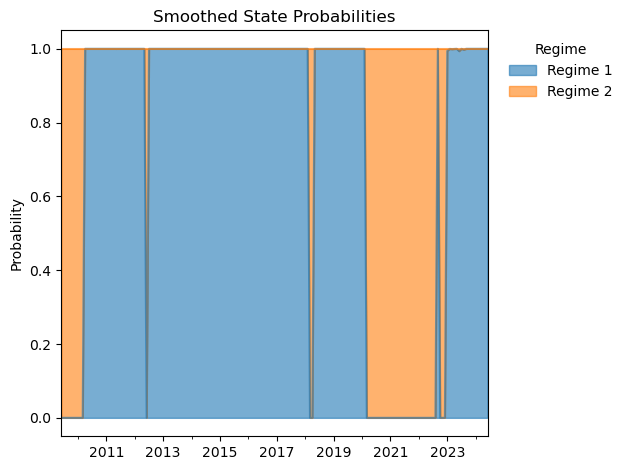

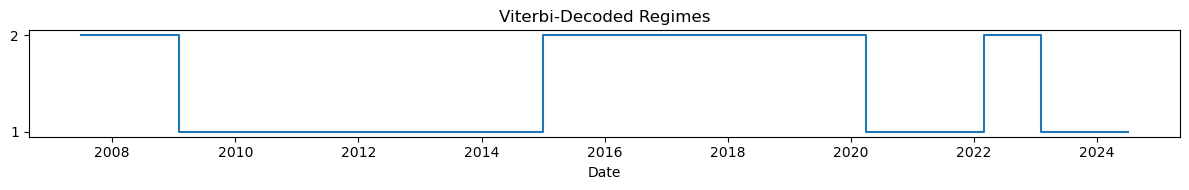

In [13]:
# STEP 3.4 (Robust): Model Validation & OOS ΔLL, Smoothed Probs, Viterbi
# ───────────────────────────────────────────────────────────────────────
from xaiR2_utils import validate_hmm

# Reconstruct the HMM training array
train_end = '2010-05-31'  
training_data = df_scaled_regime.loc[:train_end].values

# Run Vuong/AIC/BIC/OOS backtest and plots
model1, modelk, metrics = validate_hmm(
    training_data,
    best_k,
    df_scaled_regime,
    df_probs,
    test_start='2010-06-01'
)

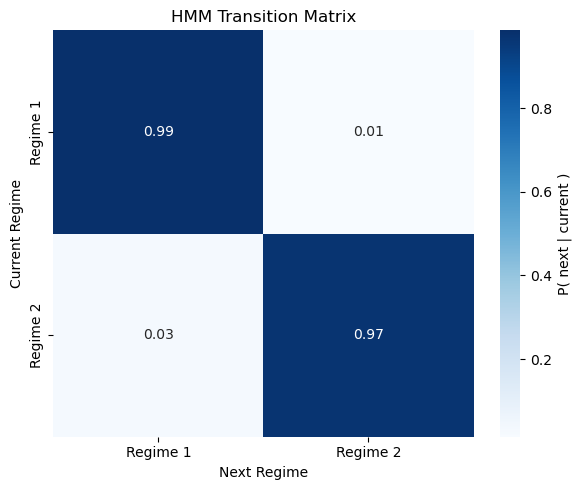

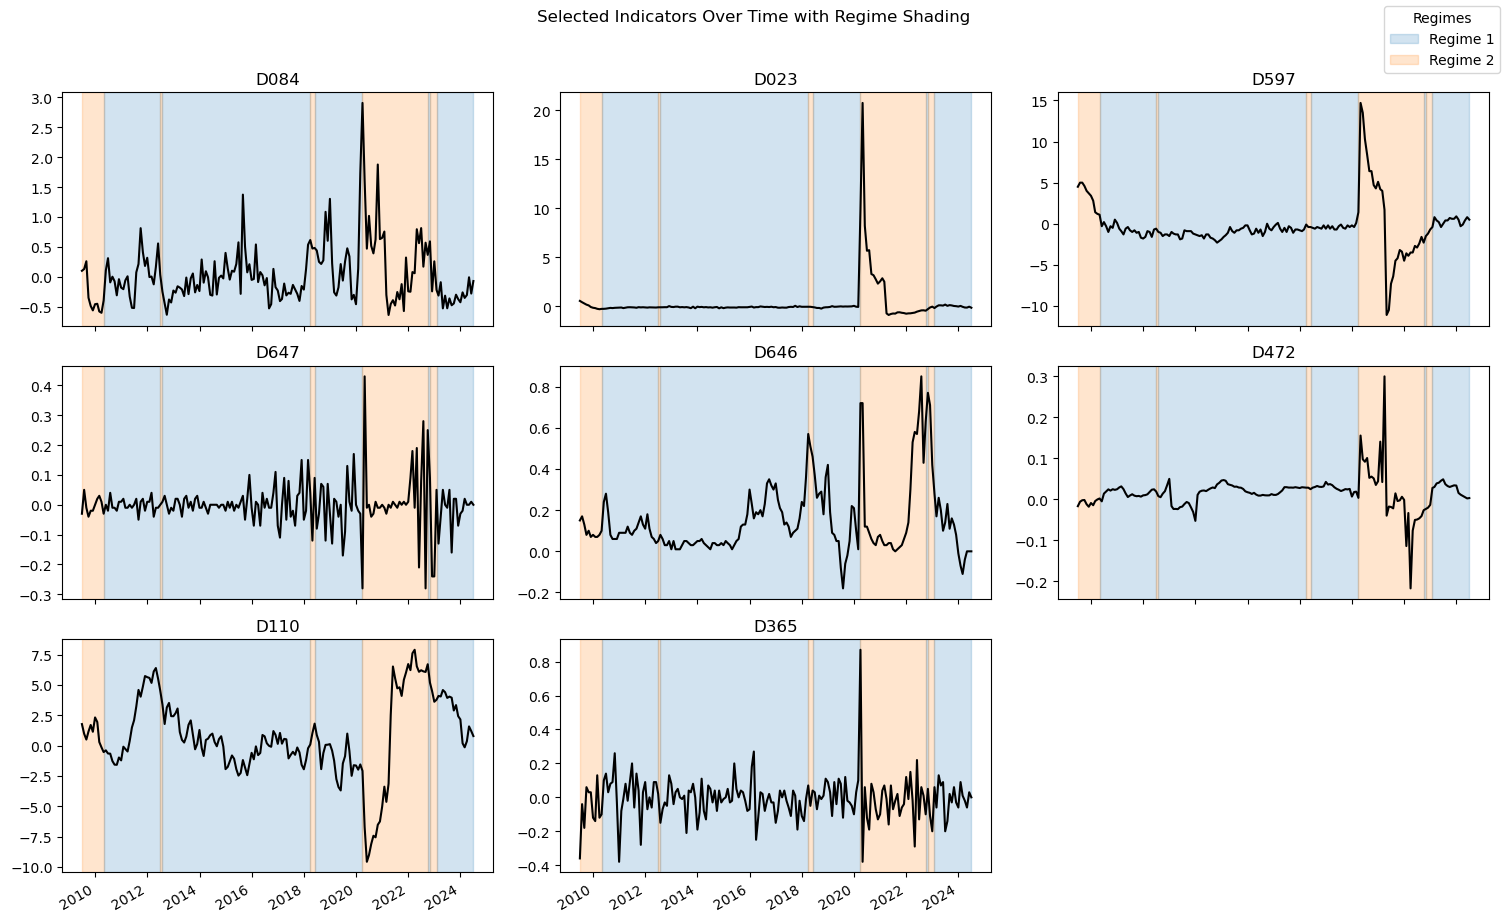

In [14]:
# STEP 3.5: Transition Matrix & Shaded Time‐Series
# ──────────────────────────────────────────────────
from xaiR2_utils import plot_transition_matrix, plot_indicators_shaded

# Heatmap of transition probabilities
plot_transition_matrix(final_model)

# Small multiples of each indicator with regime shading
plot_indicators_shaded(
    df_reduced_imputed,
    df_probs,
    selected_indicators
)

In‑sample L1‑logit accuracy: 81.77%


,D084,D023,D597,D647,D646,D472,D110,D365,Duration
Regime 1,-0.078805,-0.551946,-0.0,-0.0,-0.19154,-0.0,-0.154309,-0.0,0.023989
Regime 2,0.078805,0.551946,0.0,0.0,0.19154,0.0,0.154309,0.0,-0.023989


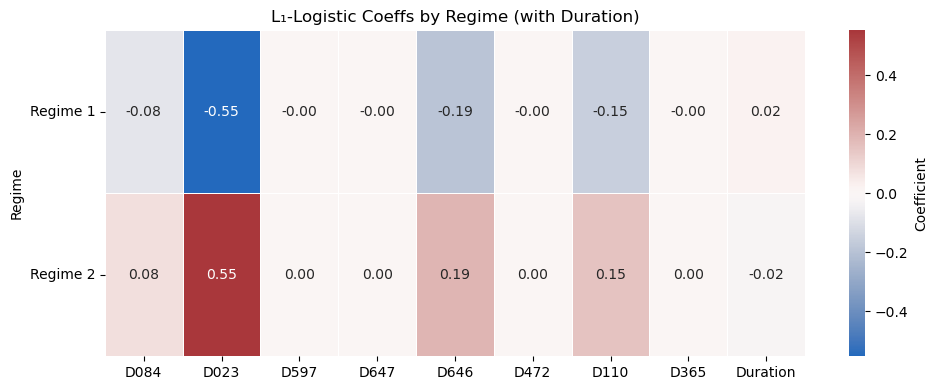

Top features from CV surrogate tree: ['D023', 'D597', 'D084', 'D647', 'D646']
Mean CV surrogate‑tree accuracy: 93.92%


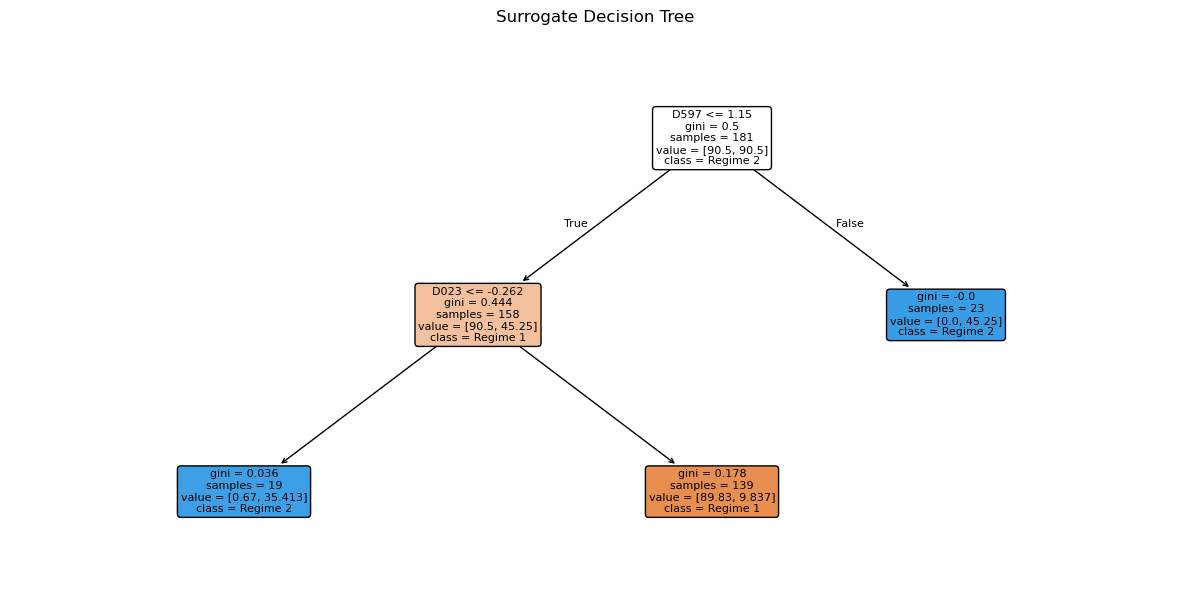

In [15]:
# STEP 3.6: Glass‑box via L1‑Logistic Regression & Surrogate Tree

from xaiR2_utils import (
    fit_l1_logistic,
    plot_l1_coeffs,
    fit_surrogate_tree,
    plot_surrogate_tree_model
)

# alias posterior DataFrame
final_regime_probs = df_probs.copy()

# build standardized regime‐data subset for Steps 3.6–3.7
df_regime_std = df_scaled_regime.loc[final_regime_probs.index].copy()

# 1) L1‑logistic
clf_lr, X_lr, y_lr, acc_lr, coef_df = fit_l1_logistic(
    df_regime_std,
    final_regime_probs,
    selected_indicators
)
print(f"In‑sample L1‑logit accuracy: {acc_lr:.2%}")
display(coef_df)
plot_l1_coeffs(coef_df)

# 3.6 (CV‑tuned) Surrogate decision tree
surrogate, X_tree, y_tree, top_feats, tree_acc = fit_surrogate_tree(
    df_regime_std,
    final_regime_probs,
    selected_indicators,
    max_depth_options=[2,3,4],
    min_samples_leaf_options=[5,10,20],
    cv_folds=5,
    random_state=0
)

print("Top features from CV surrogate tree:", top_feats)
print(f"Mean CV surrogate‑tree accuracy: {tree_acc:.2%}")

plot_surrogate_tree_model(
    surrogate,
    feature_names=selected_indicators,
    class_names=[f"Regime {c}" for c in surrogate.classes_]
)


--- Tree: depth2_leaf5_featsqrt ---
|--- D023 <= -0.26
|   |--- D646 <= 0.57
|   |   |--- class: 2
|   |--- D646 >  0.57
|   |   |--- class: 2
|--- D023 >  -0.26
|   |--- D597 <= 1.25
|   |   |--- class: 1
|   |--- D597 >  1.25
|   |   |--- class: 2

--- Tree: depth2_leaf5_featNone ---
|--- D597 <= 1.15
|   |--- D023 <= -0.26
|   |   |--- class: 2
|   |--- D023 >  -0.26
|   |   |--- class: 1
|--- D597 >  1.15
|   |--- class: 2

--- Tree: depth2_leaf10_featsqrt ---
|--- D023 <= -0.26
|   |--- D646 <= 0.12
|   |   |--- class: 2
|   |--- D646 >  0.12
|   |   |--- class: 2
|--- D023 >  -0.26
|   |--- D597 <= 1.25
|   |   |--- class: 1
|   |--- D597 >  1.25
|   |   |--- class: 2

--- Tree: depth2_leaf10_featNone ---
|--- D597 <= 1.15
|   |--- D023 <= -0.26
|   |   |--- class: 2
|   |--- D023 >  -0.26
|   |   |--- class: 1
|--- D597 >  1.15
|   |--- class: 2

--- Tree: depth2_leaf20_featNone ---
|--- D597 <= 1.15
|   |--- D023 <= -0.25
|   |   |--- class: 2
|   |--- D023 >  -0.25
|   |   |--

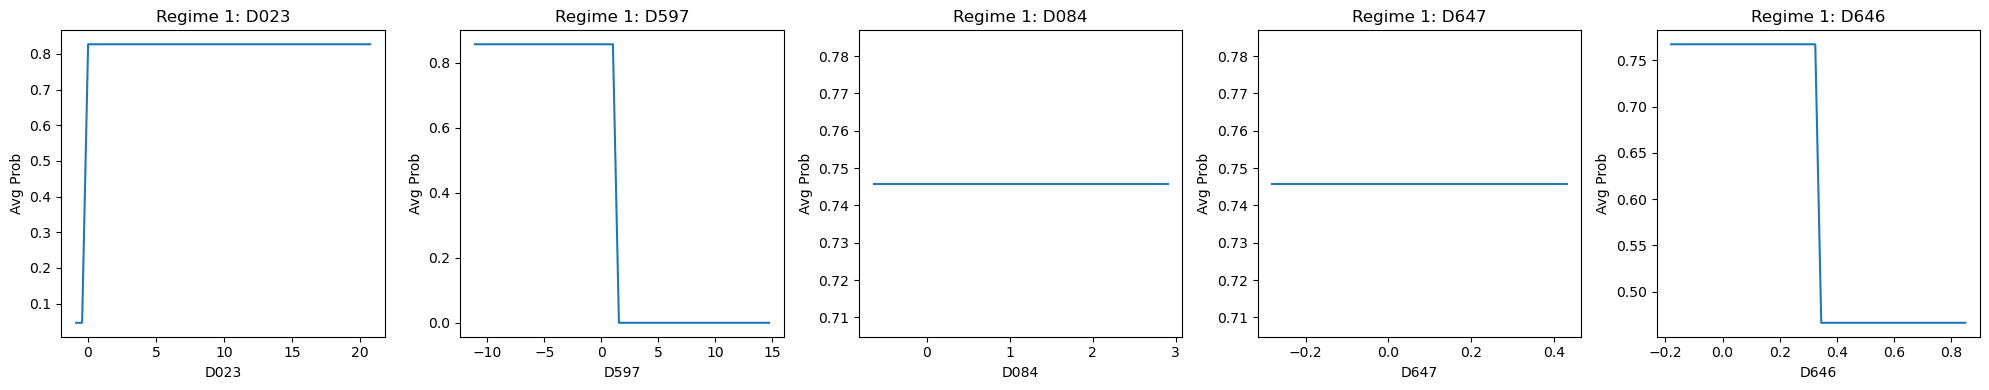

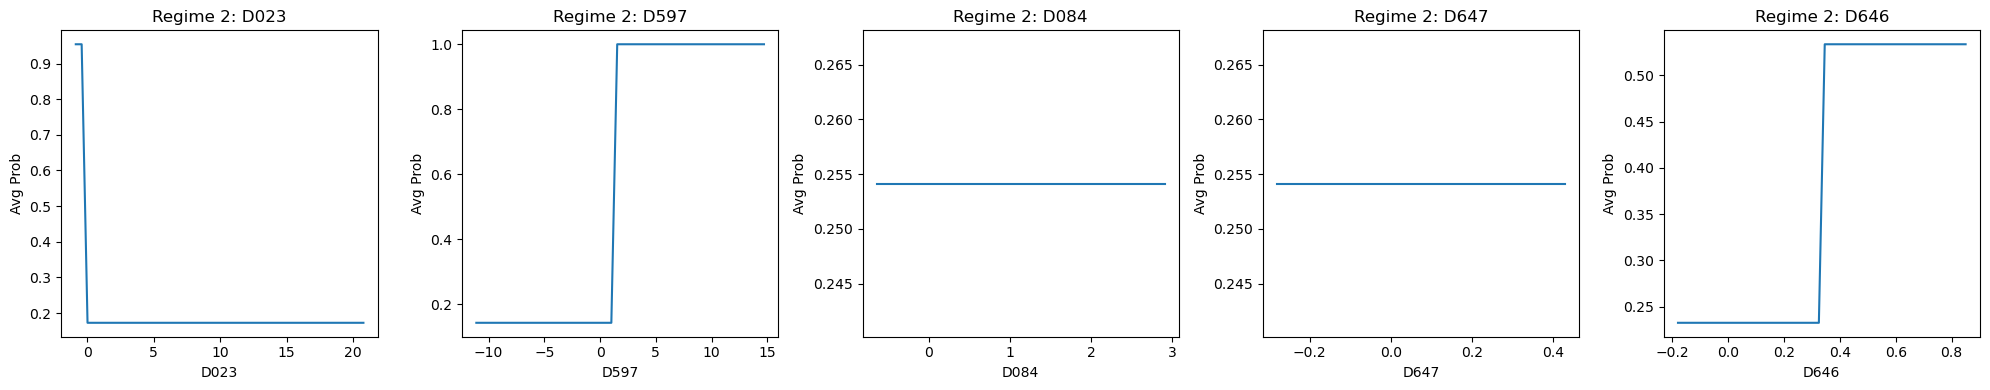

In [16]:
# STEP 3.7′: Manual Fine‑Tuned Decision Trees for Explainability
from manual_tree_utils import (
    grid_surrogate_trees,
    select_pareto_models,
    extract_rules,
    fit_ova_trees,
    plot_manual_partial_dependence
)

# 1) Grid search over shallow trees
candidates = grid_surrogate_trees(
    X_tree, y_tree,
    param_grid={
        'max_depth': [2, 3, 4],
        'min_samples_leaf': [5, 10, 20],
        'max_features': ['sqrt', None]
    }
)

# 2) Select Pareto‑optimal models within 2% of best accuracy
selected_models = select_pareto_models(candidates, performance_threshold=0.02)

# 3) Extract and print rules
for name, model in selected_models.items():
    print(f"--- Tree: {name} ---")
    for rule in extract_rules(model, feature_names=X_tree.columns):
        print(rule)

# 4) One‑vs‑All trees for each regime
ova_models = fit_ova_trees(X_tree, y_tree)
for regime, model in ova_models.items():
    print(f"=== One‑vs‑All: {regime} ===")
    for rule in extract_rules(model, feature_names=X_tree.columns):
        print(rule)

# 5) Partial Dependence plots for selected features
#    Use top_feats from Step 3.6
features = top_feats
plot_manual_partial_dependence(ova_models, X_tree, features)

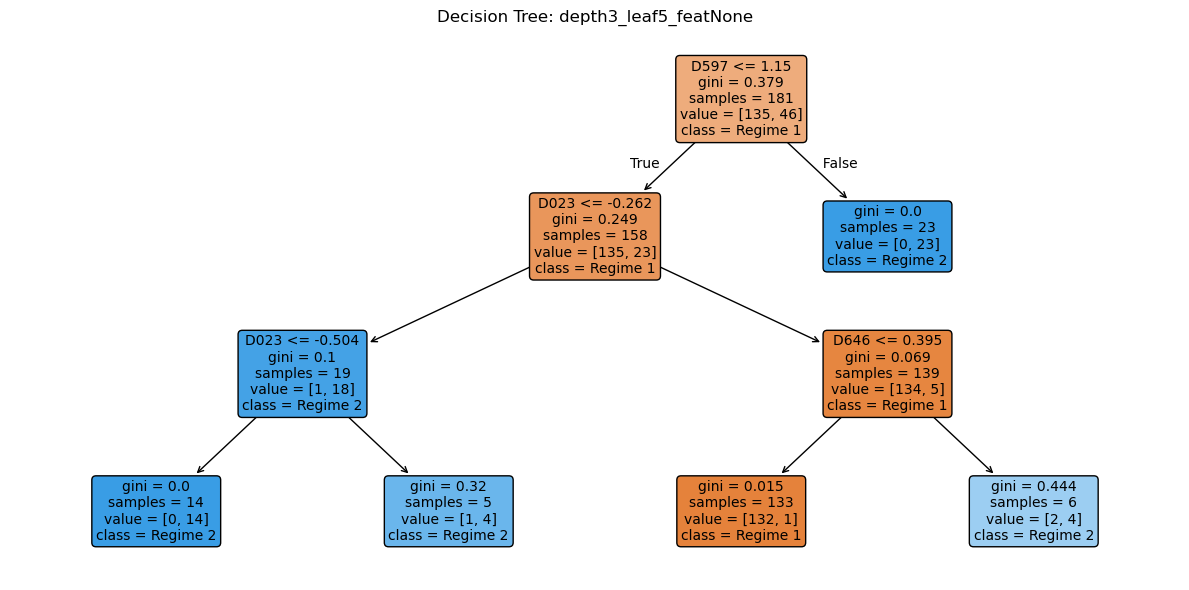

In [17]:
# Visualize best Dtree model

from manual_tree_utils import plot_best_tree

best_name, best_model = plot_best_tree(
    selected_models,
    candidates,
    X_tree
)

In [2]:
# STEP 3.8: Import & clean LendingClub “accepted” CSV (2007–2018Q4)
# RUN AGAIN after loading safed workfile, due to large size of df_loans
import pandas as pd

# 1) Load the data and parse any date-like columns
#    (we’ll parse ‘issue_d’ explicitly for full coverage)
df_loans = pd.read_csv(
    "accepted_2007_to_2018Q4.csv",   # or .csv if uncompressed
    low_memory=False
)

# 2) Rename & parse the main issue date
df_loans.rename(columns={"issue_d": "issue_date"}, inplace=True)
# issue_date in format "Dec-2015" → use pandas to parse
df_loans["issue_date"] = pd.to_datetime(
    df_loans["issue_date"], format="%b-%Y"
)

# Filter to the sample period (June 2007–Dec 2012)
df_loans = df_loans[
    (df_loans["issue_date"] >= "2007-06-01") &
    (df_loans["issue_date"] <= "2012-12-31")
].copy()


# 3) Clean up int_rate & revol_util
for pctcol in ["int_rate", "revol_util"]:
    if df_loans[pctcol].dtype == object:
        df_loans[pctcol] = (
            df_loans[pctcol].str.rstrip("%")
                            .astype(float)
                            .div(100)
        )
    else:
        if df_loans[pctcol].max() > 1:
            df_loans[pctcol] = df_loans[pctcol].div(100)


# 4) Standardize term to “36 months”/“60 months” (if you need it later as string)
df_loans["term"] = df_loans["term"].str.strip()

# Keep funded originations; include all ex-post outcomes
valid_status = [
    "Current", "Fully Paid", "Charged Off", "Default",
    "Late (31-120 days)", "Late (16-30 days)", "In Grace Period",
    "Does not meet the credit policy. Status: Fully Paid",
    "Does not meet the credit policy. Status: Charged Off",
    # some files use these variants:
    "Issued", "Grace Period", "Late (16-30 days)", "Late (31-120 days)"
]

# keep if funded and a recognized, funded status
df_loans = df_loans[
    (df_loans["funded_amnt"].fillna(0) > 0) &
    (df_loans["loan_status"].isin(valid_status))
].copy()

# 6) Now detect your key columns exactly as before:

# a) find all date columns (we already have issue_date parsed)
all_cols    = df_loans.columns.tolist()
date_cols   = [c for c in all_cols if "date" in c.lower() or "year" in c.lower()]

# b) detect credit-term columns by keyword
keywords = [
    "loan", "int_rate", "term",
    "grade","sub_grade","pymnt_plan",
    "purpose","application_type",
    "initial_list_status"
]
credit_term_cols = [c for c in all_cols if c.lower() in keywords]

print("Date cols:\n", date_cols)
print("Credit-term cols:\n", credit_term_cols)

# 7) Subset to only date + credit-term fields
cols_to_keep = date_cols + credit_term_cols
loan_terms_with_time = df_loans[cols_to_keep]

# 8) Quick preview
print(loan_terms_with_time.head())
print("\nLoan issuance spans from",
      loan_terms_with_time["issue_date"].min().date(), "to",
      loan_terms_with_time["issue_date"].max().date())


Date cols:
 ['issue_date', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'debt_settlement_flag_date', 'settlement_date']
Credit-term cols:
 ['term', 'int_rate', 'grade', 'sub_grade', 'pymnt_plan', 'purpose', 'initial_list_status', 'application_type']
        issue_date hardship_start_date hardship_end_date  \
1611879 2011-12-01                 NaN               NaN   
1611880 2011-12-01                 NaN               NaN   
1611881 2011-12-01                 NaN               NaN   
1611882 2011-12-01                 NaN               NaN   
1611883 2011-12-01                 NaN               NaN   

        payment_plan_start_date debt_settlement_flag_date settlement_date  \
1611879                     NaN                       NaN             NaN   
1611880                     NaN                       NaN             NaN   
1611881                     NaN                       NaN             NaN   
1611882                     NaN                       N

In [3]:
# STEP 3.9: Loan‐Level Data Summary (Numeric vs. Categorical) for 2007–2018 CSV
import numpy as np
import pandas as pd

# 1) Define your 20 “core” numeric columns
core_numeric = [
    "loan_amnt",
    "funded_amnt",
    "funded_amnt_inv",
    "int_rate",
    "installment",
    "annual_inc",
    "dti",
    "delinq_2yrs",
    "inq_last_6mths",
    "open_acc",
    "revol_bal",
    "revol_util",
    "total_acc",
    "fico_range_low",
    "fico_range_high",
    "acc_open_past_24mths",
    "avg_cur_bal",
    "num_actv_rev_tl",
    "percent_bc_gt_75",
    "mort_acc"
]

# 2) Filter to only those that actually exist in your df
core_numeric = [c for c in core_numeric if c in df_loans.columns]

# 3) Compute & display their descriptives
print("### Descriptive stats for core numeric fields:\n")
desc = df_loans[core_numeric].describe().T
desc = desc[["count","mean","std","min","25%","50%","75%","max"]]  # reorder if you like
print(desc)

# --- 4. Credit‐term fields: split numeric vs. categorical ---
# Define your credit‐term columns explicitly
credit_term_cols = [
    'loan_amnt', 'int_rate', 'term',
    'grade', 'sub_grade', 'pymnt_plan',
    'purpose', 'initial_list_status',
    'application_type'
]

# 4a) Numeric summary
# Convert 'term' from strings ("36 months"/"60 months") → numeric months
df_loans['term_num'] = df_loans['term'].str.extract(r'(\d+)').astype(float)
numeric_cols = ['loan_amnt', 'int_rate', 'term_num']
print(f"\n=== Numeric Credit‐Term Stats ({numeric_cols}) ===")
print(df_loans[numeric_cols].describe().T)

# 4b) Categorical distributions (counts + top 5 proportions)
cat_cols = ['grade','sub_grade','pymnt_plan',
            'purpose','initial_list_status','application_type']
for col in cat_cols:
    freq = df_loans[col].value_counts().head(5)
    pct  = df_loans[col].value_counts(normalize=True).mul(100).round(2).head(5)
    summary = pd.concat([freq, pct], axis=1)
    summary.columns = ['Count','Percent']
    print(f"\n--- Top 5 levels of {col!r} ---")
    print(summary)

# --- 5. Time span of loan issuances ---
earliest = df_loans['issue_date'].min().date()
latest   = df_loans['issue_date'].max().date()
print(f"\nLoan issuance spans from {earliest} to {latest}")

# --- 6. Loans per year (to check coverage across 2007–2012) ---
print("\n=== Loans per Year ===")
print(df_loans['issue_date'].dt.year.value_counts().sort_index())


### Descriptive stats for core numeric fields:

                        count          mean           std        min  \
loan_amnt             93153.0  12509.118601   7904.495632   500.0000   
funded_amnt           93153.0  12387.645594   7811.088236   500.0000   
funded_amnt_inv       93153.0  12139.640678   7826.090592     0.0000   
int_rate              93153.0      0.129502      0.041855     0.0542   
installment           93153.0    380.380343    235.831198    15.6900   
annual_inc            93153.0  69403.678233  60889.427890  4000.0000   
dti                   93153.0     15.233307      7.400542     0.0000   
delinq_2yrs           93153.0      0.178116      0.579504     0.0000   
inq_last_6mths        93153.0      0.846672      1.037229     0.0000   
open_acc              93153.0     10.055028      4.488109     1.0000   
revol_bal             93153.0  14370.937426  15287.651308     0.0000   
revol_util            93056.0      0.540390      0.264432     0.0000   
total_acc       

In [4]:
# 6. (Optional) Number of loans per year
print("\n=== Loans per Year ===")
print(df_loans['issue_date'].dt.year.value_counts().sort_index())


=== Loans per Year ===
issue_date
2007      251
2008     1562
2009     4716
2010    11536
2011    21721
2012    53367
Name: count, dtype: int64


In [5]:
# STEP 3.9b: Improved categorical summaries with counts + finer-grained percentages
import pandas as pd
from IPython.display import display, Markdown

cat_cols = [
    'grade',
    'sub_grade',
    'pymnt_plan',
    'purpose',
    'initial_list_status',
    'application_type'
]

N = len(df_loans)

for col in cat_cols:
    # include NaNs in the count
    freq = df_loans[col].value_counts(dropna=False)
    pct  = (freq / N * 100).round(3)

    summary = pd.DataFrame({
        'Count': freq,
        'Percent': pct.astype(str) + '%'
    })

    display(Markdown(f"### `{col}` distribution (top 5 of {len(freq)} levels; N={N})"))
    with pd.option_context('display.max_rows', 5):
        display(summary)


### `grade` distribution (top 5 of 7 levels; N=93153)

,Count,Percent
grade,,
B,30542,32.787%
A,20986,22.529%
...,...,...
F,2369,2.543%
G,579,0.622%


### `sub_grade` distribution (top 5 of 35 levels; N=93153)

,Count,Percent
sub_grade,,
B3,8253,8.86%
B4,6386,6.855%
...,...,...
G3,80,0.086%
G5,47,0.05%


### `pymnt_plan` distribution (top 5 of 1 levels; N=93153)

,Count,Percent
pymnt_plan,,
n,93153,100.0%


### `purpose` distribution (top 5 of 14 levels; N=93153)

,Count,Percent
purpose,,
debt_consolidation,49487,53.124%
credit_card,15502,16.641%
...,...,...
educational,325,0.349%
renewable_energy,174,0.187%


### `initial_list_status` distribution (top 5 of 2 levels; N=93153)

,Count,Percent
initial_list_status,,
f,89251,95.811%
w,3902,4.189%


### `application_type` distribution (top 5 of 1 levels; N=93153)

,Count,Percent
application_type,,
Individual,93153,100.0%


In [6]:
# ──────────────────────────────────────────────────────────────────────────────
# STEP 4.0: Attach Macro Exposures + Matched Risk-Free Rate to Each Loan
# ──────────────────────────────────────────────────────────────────────────────

import pandas as pd
import numpy as np
from pandas_datareader import data as pdr

# 0) Prereqs (in your namespace already):
#    • df_loans:    loan-level DataFrame with 'issue_date' as datetime
#    • df0:         un-stationarized macro panel (indexed by date)
#    • top_feats:   list[str] of your 5 selected ask_ids, e.g. ['D597','D102','D604','D084','D593']

# 1) Ensure you have a Year-Month key for merging
if "ym" not in df_loans.columns:
    df_loans["ym"] = (
        df_loans["issue_date"]
          .dt.to_period("M")
          .dt.to_timestamp("M")
    )

# 2) Pull 3- and 5-year Treasury yields from FRED and convert to decimal
start, end = df_loans["ym"].min(), df_loans["ym"].max()
yields = (
    pdr.DataReader(["DGS3","DGS5"], "fred", start, end)
      .div(100)                # percent → decimal
      .resample("M").last()    # month-end
)

# 3) Reset the yields index into a mergeable column 'ym'
idx_name = yields.index.name or "index"
yields_reset = (
    yields
      .reset_index()
      .rename(columns={idx_name: "ym", "DGS3": "RF_3yr", "DGS5": "RF_5yr"})
)

# 4) Merge those yields into your loans (many loans per single monthly yield)
df_loans = df_loans.merge(
    yields_reset,
    on="ym",
    how="left",
    validate="m:1"
)

# 5) Match each loan’s term to the proper risk-free (36→3yr, else→5yr)
df_loans["term_num"] = df_loans["term"].str.extract(r"(\d+)").astype(int)
df_loans["RF_match"] = np.where(
    df_loans["term_num"] == 36,
    df_loans["RF_3yr"],
    df_loans["RF_5yr"]
)

# 6) Prepare your top_feats panel for merging
raw_macro = (
    df0[top_feats]
      .rename_axis("Date")  # name the date index
      .reset_index()        # push it into a column
)

# 7) Merge in your selected macro drivers
df_loans = (
    df_loans
      .merge(
         raw_macro[["Date"] + top_feats],
         left_on="ym",
         right_on="Date",
         how="left",
         validate="m:1"
      )
      .drop(columns="Date")
)

# 8) Sanity check – first 5 rows of everything we just attached
print(
    df_loans.loc[
      :4,
      ["issue_date","ym","term_num","RF_3yr","RF_5yr","RF_match"] + top_feats
    ]
)

  issue_date         ym  term_num  RF_3yr  RF_5yr  RF_match      D023  D597  \
0 2011-12-01 2011-12-31        36  0.0036  0.0083    0.0036 -0.108864  -1.8   
1 2011-12-01 2011-12-31        60  0.0036  0.0083    0.0083 -0.108864  -1.8   
2 2011-12-01 2011-12-31        36  0.0036  0.0083    0.0036 -0.108864  -1.8   
3 2011-12-01 2011-12-31        36  0.0036  0.0083    0.0036 -0.108864  -1.8   
4 2011-12-01 2011-12-31        60  0.0036  0.0083    0.0083 -0.108864  -1.8   

      D084  D647  D646  
0  0.31831 -0.06  0.11  
1  0.31831 -0.06  0.11  
2  0.31831 -0.06  0.11  
3  0.31831 -0.06  0.11  
4  0.31831 -0.06  0.11  


In [7]:
# Any missing exposures?
print(df_loans[top_feats].isna().sum())

# How many unique issuance months made it through?
print(df_loans['ym'].nunique(), "distinct months vs", df_loans['ym'].unique()[:5])

D023    0
D597    0
D084    0
D647    0
D646    0
dtype: int64
67 distinct months vs <DatetimeArray>
['2011-12-31 00:00:00', '2011-11-30 00:00:00', '2011-10-31 00:00:00',
 '2011-09-30 00:00:00', '2011-08-31 00:00:00']
Length: 5, dtype: datetime64[ns]


In [8]:
# ──────────────────────────────────────────────────────────────────────────────
#  STEP 4.1: Credit‐Spread Regressions by Grade & by Term
# ──────────────────────────────────────────────────────────────────────────────


# --- A) Merge RegimeLabel into df_loans ---

# 1) Turn df_probs.index into a Date column
regime_df = (
    df_probs[['RegimeLabel']]          # just the label
      .rename_axis("Date")             # name the index
      .reset_index()                   # make it a column
)

# 2) Merge onto loans by ym → Date
df_loans = (
    df_loans
      .merge(
          regime_df,
          left_on="ym",
          right_on="Date",
          how="left"
      )
      .drop(columns="Date")           # clean up
)

# Check it came through
print(df_loans[['issue_date','ym','RegimeLabel']].head())

  issue_date         ym  RegimeLabel
0 2011-12-01 2011-12-31          1.0
1 2011-12-01 2011-12-31          1.0
2 2011-12-01 2011-12-31          1.0
3 2011-12-01 2011-12-31          1.0
4 2011-12-01 2011-12-31          1.0


In [9]:
# find the first date where you actually have a posterior label
first_label = df_probs.index.min().date()

# restrict to loans issued on or after that date
df_loans = df_loans[df_loans['issue_date'].dt.date >= first_label].copy()

# verify no more missing regime labels
print("Number of missing labels:", df_loans["RegimeLabel"].isna().sum())

Number of missing labels: 0


In [10]:
print("Unique RegimeLabel values:", sorted(df_loans["RegimeLabel"].unique().tolist()))
print("Counts by regime:\n", df_loans["RegimeLabel"].value_counts())

Unique RegimeLabel values: [1.0, 2.0]
Counts by regime:
 RegimeLabel
1.0    80854
2.0     8746
Name: count, dtype: int64


In [11]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

# ──────────────────────────────────────────────────────────────────────────────
# PREPARE YOUR DATA
# ──────────────────────────────────────────────────────────────────────────────
# 0) df_loans must already have:
#    • int_rate  (decimal, e.g. 0.15 for 15%)
#    • RF_match  (matched risk-free yield per loan)
#    • term      (string, e.g. "36 months")
#    • dti, annual_inc, grade, RegimeLabel, ym (end-of-month), plus your top_feats
#
# 1) Numeric fields & credit spread
df_loans['term_num']      = df_loans['term'].str.extract(r'(\d+)').astype(int)
df_loans['credit_spread'] = df_loans['int_rate'] - df_loans['RF_match']
df_loans['Contraction']   = (df_loans['RegimeLabel']==2).astype(int)

# Composition by regime
grade_share_by_regime = pd.crosstab(df_loans['grade'], df_loans['Contraction'], normalize='columns')
term_share_by_regime  = pd.crosstab(df_loans['term_num'], df_loans['Contraction'], normalize='columns')
print("\nGrade mix by regime (column shares):\n", grade_share_by_regime.round(3))
print("\nTerm mix by regime (column shares):\n", term_share_by_regime.round(3))

# Optional: Chi-square test
from scipy.stats import chi2_contingency
chi_grade = chi2_contingency(pd.crosstab(df_loans['grade'], df_loans['Contraction']))[1]
chi_term  = chi2_contingency(pd.crosstab(df_loans['term_num'], df_loans['Contraction']))[1]
print(f"\nChi-square p-value (grade vs regime): {chi_grade:.4f}")
print(f"Chi-square p-value (term vs regime):  {chi_term:.4f}")


Grade mix by regime (column shares):
 Contraction      0      1
grade                    
A            0.226  0.215
B            0.330  0.331
C            0.210  0.233
D            0.135  0.140
E            0.067  0.054
F            0.026  0.021
G            0.006  0.006

Term mix by regime (column shares):
 Contraction      0      1
term_num                 
36           0.755  0.912
60           0.245  0.088

Chi-square p-value (grade vs regime): 0.0000
Chi-square p-value (term vs regime):  0.0000


In [12]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf


# 2) Build formula pieces
macro_terms = " + ".join(top_feats)
ctrl_expr   = " + term_num + dti + np.log(annual_inc)"

# ──────────────────────────────────────────────────────────────────────────────
# A) Grade-Specific Regressions (full sample, no per-month cap)
# ──────────────────────────────────────────────────────────────────────────────
print(">>> Grade‐specific credit‐spread regressions (full sample) <<<\n")
grade_results = {}

for grade in sorted(df_loans['grade'].dropna().unique()):
    # filter + drop loans missing any needed variable
    needed = ['credit_spread','term_num','dti','annual_inc','Contraction'] + top_feats
    df_g = df_loans[df_loans['grade']==grade].dropna(subset=needed)
    
    # fit OLS on full df_g
    formula = f"credit_spread ~ Contraction + {macro_terms}{ctrl_expr}"
    res = smf.ols(formula, data=df_g).fit(
        cov_type='cluster',
        cov_kwds={'groups': df_g['ym']}
    )
    grade_results[grade] = res
    
    print(f"--- Grade {grade} (N={len(df_g):d}) ---")
    print(res.summary().tables[1])
    print()

# ──────────────────────────────────────────────────────────────────────────────
# B) Term-Specific Regressions (full sample, no per-month cap)
# ──────────────────────────────────────────────────────────────────────────────
print("\n>>> Term‐specific credit‐spread regressions (full sample) <<<\n")
term_results = {}

for term in sorted(df_loans['term_num'].dropna().unique()):
    # filter + drop loans missing any needed variable
    needed = ['credit_spread','dti','annual_inc','Contraction'] + top_feats
    df_t = df_loans[df_loans['term_num']==term].dropna(subset=needed)
    
    # fit OLS with grade dummies
    formula = (
        f"credit_spread ~ Contraction + {macro_terms}"
        f" + C(grade) + dti + np.log(annual_inc)"
    )
    res = smf.ols(formula, data=df_t).fit(
        cov_type='cluster',
        cov_kwds={'groups': df_t['ym']}
    )
    term_results[term] = res
    
    print(f"--- Term {term}-month (N={len(df_t):d}) ---")
    print(res.summary().tables[1])
    print()

>>> Grade‐specific credit‐spread regressions (full sample) <<<

--- Grade A (N=20186) ---
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0635      0.003     18.264      0.000       0.057       0.070
Contraction            0.0063      0.003      1.787      0.074      -0.001       0.013
D023                   0.0352      0.007      5.415      0.000       0.022       0.048
D597                  -0.0026      0.001     -2.852      0.004      -0.004      -0.001
D084                  -0.0004      0.002     -0.183      0.855      -0.005       0.004
D647                  -0.0448      0.040     -1.125      0.261      -0.123       0.033
D646                  -0.0037      0.016     -0.235      0.814      -0.035       0.027
term_num            -7.23e-05    7.7e-05     -0.939      0.348      -0.000    7.86e-05
dti                    0.0002   1.43e-05

In [13]:
# Display results of each model 

from IPython.display import display, Markdown

for grade, res in grade_results.items():
    display(Markdown(f"## Grade {grade} (N={int(res.nobs)})"))
    display(res.summary())   # will render the full summary object

for term, res in term_results.items():
    display(Markdown(f"## Term {term}-month (N={int(res.nobs)})"))
    display(res.summary())


## Grade A (N=20186)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          credit_spread   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     27.86
Date:                Tue, 09 Sep 2025   Prob (F-statistic):           9.83e-15
Time:                        13:28:20   Log-Likelihood:                 64272.
No. Observations:               20186   AIC:                        -1.285e+05
Df Residuals:                   20176   BIC:                        -1.284e+05
Df Model:                           9                                         
Covariance Type:              cluster                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0635      0.003     18.264      0.000       0.057       0.070
Contraction            0.0063      0.003      1.787      0.074      -0.001       0.013
D023                   0.0352      0.007      5.415      0.000       0.022       0.048
D597                  -0.0026      0.001     -2.852      0.004      -0.004      -0.001
D084                  -0.0004      0.002     -0.183      0.855      -0.005       0.004
D647                  -0.0448      0.040     -1.125      0.261      -0.123       0.033
D646                  -0.0037      0.016     -0.235      0.814      -0.035       0.027
term_num            -7.23e-05    7.7e-05     -0.939      0.348      -0.000    7.86e-05
dti                    0.0002   1.43e-05     13.443      0.000       0.000       0.000
np.log(annual_inc)     0.0003      0.000      2.012      0.044    8.97e-06       0.001
==============================================================================
Omnibus:                     1364.758   Durbin-Watson:                   1.606
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              569.286
Skew:                          -0.186   Prob(JB):                    2.40e-124
Kurtosis:                       2.266   Cond. No.                     2.34e+03
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The condition number is large, 2.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Grade B (N=29570)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          credit_spread   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     14.85
Date:                Tue, 09 Sep 2025   Prob (F-statistic):           2.48e-10
Time:                        13:28:20   Log-Likelihood:                 87398.
No. Observations:               29570   AIC:                        -1.748e+05
Df Residuals:                   29560   BIC:                        -1.747e+05
Df Model:                           9                                         
Covariance Type:              cluster                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1136      0.005     20.697      0.000       0.103       0.124
Contraction            0.0082      0.003      2.705      0.007       0.002       0.014
D023                   0.0508      0.008      6.157      0.000       0.035       0.067
D597                  -0.0055      0.001     -5.337      0.000      -0.008      -0.004
D084                  -0.0015      0.004     -0.404      0.686      -0.009       0.006
D647                  -0.0418      0.055     -0.760      0.447      -0.150       0.066
D646                  -0.0316      0.026     -1.199      0.231      -0.083       0.020
term_num              -0.0003   3.77e-05     -6.673      0.000      -0.000      -0.000
dti                    0.0001   2.17e-05      6.257      0.000    9.33e-05       0.000
np.log(annual_inc)     0.0004      0.000      1.142      0.254      -0.000       0.001
==============================================================================
Omnibus:                     1358.716   Durbin-Watson:                   1.502
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              558.970
Skew:                          -0.033   Prob(JB):                    4.18e-122
Kurtosis:                       2.330   Cond. No.                     2.59e+03
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The condition number is large, 2.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Grade C (N=18987)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          credit_spread   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     46.24
Date:                Tue, 09 Sep 2025   Prob (F-statistic):           1.19e-18
Time:                        13:28:20   Log-Likelihood:                 59185.
No. Observations:               18987   AIC:                        -1.183e+05
Df Residuals:                   18977   BIC:                        -1.183e+05
Df Model:                           9                                         
Covariance Type:              cluster                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1437      0.004     34.047      0.000       0.135       0.152
Contraction            0.0051      0.002      2.222      0.026       0.001       0.010
D023                   0.0483      0.007      6.470      0.000       0.034       0.063
D597                  -0.0072      0.001     -8.941      0.000      -0.009      -0.006
D084                  -0.0031      0.003     -0.891      0.373      -0.010       0.004
D647                  -0.0747      0.055     -1.360      0.174      -0.182       0.033
D646                  -0.0499      0.024     -2.065      0.039      -0.097      -0.003
term_num              -0.0003   6.19e-05     -5.299      0.000      -0.000      -0.000
dti                    0.0001   2.39e-05      4.590      0.000    6.29e-05       0.000
np.log(annual_inc)     0.0005      0.000      2.516      0.012       0.000       0.001
==============================================================================
Omnibus:                      860.990   Durbin-Watson:                   1.320
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2925.242
Skew:                          -0.084   Prob(JB):                         0.00
Kurtosis:                       4.915   Cond. No.                     2.65e+03
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The condition number is large, 2.65e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Grade D (N=12115)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          credit_spread   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     40.59
Date:                Tue, 09 Sep 2025   Prob (F-statistic):           1.29e-17
Time:                        13:28:20   Log-Likelihood:                 36941.
No. Observations:               12115   AIC:                        -7.386e+04
Df Residuals:                   12105   BIC:                        -7.379e+04
Df Model:                           9                                         
Covariance Type:              cluster                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1452      0.007     20.321      0.000       0.131       0.159
Contraction            0.0113      0.004      2.950      0.003       0.004       0.019
D023                   0.0729      0.011      6.399      0.000       0.051       0.095
D597                  -0.0109      0.001     -8.048      0.000      -0.014      -0.008
D084                  -0.0027      0.006     -0.435      0.664      -0.015       0.009
D647                  -0.0844      0.085     -0.989      0.323      -0.252       0.083
D646                  -0.0791      0.040     -1.960      0.050      -0.158    1.18e-05
term_num              -0.0001   5.37e-05     -2.660      0.008      -0.000   -3.76e-05
dti                    0.0002   4.69e-05      3.998      0.000    9.57e-05       0.000
np.log(annual_inc)     0.0021      0.000      8.345      0.000       0.002       0.003
==============================================================================
Omnibus:                     1412.495   Durbin-Watson:                   0.643
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4225.155
Skew:                          -0.621   Prob(JB):                         0.00
Kurtosis:                       5.613   Cond. No.                     2.87e+03
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The condition number is large, 2.87e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Grade E (N=5849)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          credit_spread   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     21.59
Date:                Tue, 09 Sep 2025   Prob (F-statistic):           7.08e-13
Time:                        13:28:20   Log-Likelihood:                 16309.
No. Observations:                5849   AIC:                        -3.260e+04
Df Residuals:                    5839   BIC:                        -3.253e+04
Df Model:                           9                                         
Covariance Type:              cluster                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1497      0.013     11.390      0.000       0.124       0.175
Contraction            0.0172      0.006      3.084      0.002       0.006       0.028
D023                   0.1016      0.018      5.522      0.000       0.066       0.138
D597                  -0.0140      0.002     -6.301      0.000      -0.018      -0.010
D084                  -0.0025      0.008     -0.295      0.768      -0.019       0.014
D647                  -0.1540      0.127     -1.215      0.224      -0.402       0.094
D646                  -0.0936      0.056     -1.673      0.094      -0.203       0.016
term_num              -0.0002   5.58e-05     -3.929      0.000      -0.000      -0.000
dti                    0.0003   6.75e-05      4.288      0.000       0.000       0.000
np.log(annual_inc)     0.0035      0.001      4.931      0.000       0.002       0.005
==============================================================================
Omnibus:                      726.626   Durbin-Watson:                   0.515
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2665.399
Skew:                          -0.596   Prob(JB):                         0.00
Kurtosis:                       6.085   Cond. No.                     3.43e+03
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The condition number is large, 3.43e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Grade F (N=2322)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          credit_spread   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     20.15
Date:                Tue, 09 Sep 2025   Prob (F-statistic):           2.17e-12
Time:                        13:28:20   Log-Likelihood:                 6566.4
No. Observations:                2322   AIC:                        -1.311e+04
Df Residuals:                    2312   BIC:                        -1.306e+04
Df Model:                           9                                         
Covariance Type:              cluster                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1593      0.017      9.136      0.000       0.125       0.193
Contraction            0.0176      0.006      3.120      0.002       0.007       0.029
D023                   0.1129      0.023      5.006      0.000       0.069       0.157
D597                  -0.0148      0.002     -5.906      0.000      -0.020      -0.010
D084                  -0.0020      0.009     -0.229      0.819      -0.019       0.015
D647                  -0.1542      0.135     -1.145      0.252      -0.418       0.110
D646                  -0.1092      0.060     -1.817      0.069      -0.227       0.009
term_num              -0.0002   8.34e-05     -2.928      0.003      -0.000   -8.07e-05
dti                    0.0003   9.44e-05      3.444      0.001       0.000       0.001
np.log(annual_inc)     0.0046      0.001      4.361      0.000       0.003       0.007
==============================================================================
Omnibus:                       72.540   Durbin-Watson:                   0.296
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.944
Skew:                          -0.450   Prob(JB):                     7.20e-18
Kurtosis:                       2.924   Cond. No.                     3.60e+03
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The condition number is large, 3.6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Grade G (N=571)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          credit_spread   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     21.00
Date:                Tue, 09 Sep 2025   Prob (F-statistic):           1.65e-12
Time:                        13:28:20   Log-Likelihood:                 1623.2
No. Observations:                 571   AIC:                            -3226.
Df Residuals:                     561   BIC:                            -3183.
Df Model:                           9                                         
Covariance Type:              cluster                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1931      0.023      8.400      0.000       0.148       0.238
Contraction            0.0205      0.005      4.242      0.000       0.011       0.030
D023                   0.1146      0.021      5.551      0.000       0.074       0.155
D597                  -0.0156      0.002     -7.937      0.000      -0.019      -0.012
D084                  -0.0051      0.009     -0.589      0.556      -0.022       0.012
D647                  -0.2096      0.141     -1.485      0.138      -0.486       0.067
D646                  -0.0439      0.056     -0.782      0.434      -0.154       0.066
term_num              -0.0004   8.22e-05     -4.638      0.000      -0.001      -0.000
dti                    0.0003   9.53e-05      3.498      0.000       0.000       0.001
np.log(annual_inc)     0.0027      0.001      1.980      0.048    2.72e-05       0.005
==============================================================================
Omnibus:                       10.441   Durbin-Watson:                   0.304
Prob(Omnibus):                  0.005   Jarque-Bera (JB):                9.862
Skew:                          -0.277   Prob(JB):                      0.00722
Kurtosis:                       2.672   Cond. No.                     3.37e+03
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The condition number is large, 3.37e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Term 36-month (N=69013)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          credit_spread   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     880.4
Date:                Tue, 09 Sep 2025   Prob (F-statistic):           3.80e-46
Time:                        13:28:20   Log-Likelihood:             2.0885e+05
No. Observations:               69013   AIC:                        -4.177e+05
Df Residuals:                   68998   BIC:                        -4.175e+05
Df Model:                          14                                         
Covariance Type:              cluster                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0637      0.005     13.054      0.000       0.054       0.073
C(grade)[T.B]          0.0420      0.001     56.816      0.000       0.041       0.043
C(grade)[T.C]          0.0718      0.001     65.925      0.000       0.070       0.074
C(grade)[T.D]          0.0981      0.002     49.542      0.000       0.094       0.102
C(grade)[T.E]          0.1181      0.003     39.486      0.000       0.112       0.124
C(grade)[T.F]          0.1325      0.003     38.273      0.000       0.126       0.139
C(grade)[T.G]          0.1470      0.004     40.442      0.000       0.140       0.154
Contraction            0.0059      0.002      2.535      0.011       0.001       0.010
D023                   0.0471      0.007      6.818      0.000       0.034       0.061
D597                  -0.0057      0.001     -7.527      0.000      -0.007      -0.004
D084                  -0.0019      0.003     -0.614      0.539      -0.008       0.004
D647                  -0.0487      0.047     -1.042      0.298      -0.140       0.043
D646                  -0.0371      0.022     -1.713      0.087      -0.079       0.005
dti                    0.0001    1.9e-05      7.719      0.000       0.000       0.000
np.log(annual_inc)     0.0003      0.000      0.752      0.452      -0.000       0.001
==============================================================================
Omnibus:                      273.945   Durbin-Watson:                   1.583
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              279.775
Skew:                          -0.146   Prob(JB):                     1.77e-61
Kurtosis:                       3.110   Cond. No.                     1.12e+03
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The condition number is large, 1.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Term 60-month (N=20587)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          credit_spread   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     1282.
Date:                Tue, 09 Sep 2025   Prob (F-statistic):           9.27e-39
Time:                        13:28:20   Log-Likelihood:                 58805.
No. Observations:               20587   AIC:                        -1.176e+05
Df Residuals:                   20572   BIC:                        -1.175e+05
Df Model:                          14                                         
Covariance Type:              cluster                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0316      0.013      2.437      0.015       0.006       0.057
C(grade)[T.B]          0.0328      0.002     19.713      0.000       0.030       0.036
C(grade)[T.C]          0.0597      0.002     31.888      0.000       0.056       0.063
C(grade)[T.D]          0.0904      0.002     37.411      0.000       0.086       0.095
C(grade)[T.E]          0.1112      0.003     38.727      0.000       0.106       0.117
C(grade)[T.F]          0.1309      0.003     45.078      0.000       0.125       0.137
C(grade)[T.G]          0.1438      0.003     51.239      0.000       0.138       0.149
Contraction            0.0133      0.003      3.803      0.000       0.006       0.020
D023                   0.0903      0.043      2.083      0.037       0.005       0.175
D597                  -0.0131      0.004     -3.339      0.001      -0.021      -0.005
D084                  -0.0019      0.007     -0.259      0.795      -0.016       0.012
D647                  -0.1338      0.120     -1.112      0.266      -0.370       0.102
D646                  -0.0500      0.049     -1.030      0.303      -0.145       0.045
dti                    0.0003   5.08e-05      5.563      0.000       0.000       0.000
np.log(annual_inc)     0.0028      0.001      4.762      0.000       0.002       0.004
==============================================================================
Omnibus:                     1290.710   Durbin-Watson:                   0.826
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2907.490
Skew:                          -0.407   Prob(JB):                         0.00
Kurtosis:                       4.652   Cond. No.                     1.35e+03
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The condition number is large, 1.35e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from IPython.display import display, Markdown
import pandas as pd
import numpy as np

# ──────────────────────────────────────────────────────────────────────────────
# PARAMETERS
# ──────────────────────────────────────────────────────────────────────────────
# (No per-month cap needed for VIF; we use full sample per grade/term)

# ──────────────────────────────────────────────────────────────────────────────
# COMMON FORMULA PIECES
# ──────────────────────────────────────────────────────────────────────────────
macro_terms = " + ".join(top_feats)
ctrl_expr   = " + term_num + dti + np.log(annual_inc)"
full_rhs    = "Contraction + " + macro_terms + ctrl_expr
vif_formula = "credit_spread ~ " + full_rhs

# ──────────────────────────────────────────────────────────────────────────────
# A) VIFs by Grade
# ──────────────────────────────────────────────────────────────────────────────
print("### VIF Tables by Grade (full sample)\n")
for grade in sorted(df_loans['grade'].dropna().unique()):
    # 1) filter & drop NA
    needs = ['credit_spread','term_num','dti','annual_inc','Contraction'] + top_feats
    df_g = (
        df_loans[df_loans['grade']==grade]
        .dropna(subset=needs)
    )
    
    # 2) build design matrix on full df_g
    _, Xg = dmatrices(vif_formula, data=df_g, return_type='dataframe')
    
    # 3) compute VIFs
    vif_df = pd.DataFrame({
        'variable': Xg.columns,
        'VIF': [
            variance_inflation_factor(Xg.values, i)
            for i in range(Xg.shape[1])
        ]
    })
    vif_df = (
        vif_df[vif_df.variable!='Intercept']
        .sort_values('VIF', ascending=False)
        .reset_index(drop=True)
    )
    
    # 4) display
    display(Markdown(f"## Grade {grade} (N={len(df_g)}) VIFs"))
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(vif_df)

# ──────────────────────────────────────────────────────────────────────────────
# B) VIFs by Term
# ──────────────────────────────────────────────────────────────────────────────
print("\n### VIF Tables by Term (full sample)\n")
for term in sorted(df_loans['term_num'].dropna().unique()):
    # 1) filter & drop NA
    needs = ['credit_spread','dti','annual_inc','Contraction'] + top_feats
    df_t = (
        df_loans[df_loans['term_num']==term]
        .dropna(subset=needs)
    )
    
    # 2) build design matrix on full df_t
    t_rhs = "Contraction + " + macro_terms + " + C(grade) + dti + np.log(annual_inc)"
    _, Xt = dmatrices("credit_spread ~ " + t_rhs, data=df_t, return_type='dataframe')
    
    # 3) compute VIFs
    vif_df = pd.DataFrame({
        'variable': Xt.columns,
        'VIF': [
            variance_inflation_factor(Xt.values, i)
            for i in range(Xt.shape[1])
        ]
    })
    vif_df = (
        vif_df[vif_df.variable!='Intercept']
        .sort_values('VIF', ascending=False)
        .reset_index(drop=True)
    )
    
    # 4) display
    display(Markdown(f"## Term {term}-month (N={len(df_t)}) VIFs"))
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(vif_df)

### VIF Tables by Grade (full sample)



## Grade A (N=20186) VIFs

,variable,VIF
0,D597,2.508403
1,Contraction,2.150072
2,D646,1.689795
3,D084,1.554151
4,D647,1.376614
5,D023,1.173283
6,dti,1.076133
7,np.log(annual_inc),1.066634
8,term_num,1.016070


## Grade B (N=29570) VIFs

,variable,VIF
0,D597,2.439224
1,Contraction,2.083669
2,D646,1.816197
3,D084,1.610102
4,D647,1.413013
5,D023,1.165351
6,dti,1.088552
7,term_num,1.055127
8,np.log(annual_inc),1.048483


## Grade C (N=18987) VIFs

,variable,VIF
0,D597,2.534899
1,Contraction,2.127673
2,D646,1.871305
3,D084,1.576173
4,D647,1.416730
5,D023,1.183928
6,dti,1.085322
7,term_num,1.067556
8,np.log(annual_inc),1.052885


## Grade D (N=12115) VIFs

,variable,VIF
0,D597,2.342294
1,Contraction,2.030222
2,D646,1.881196
3,D084,1.611275
4,D647,1.377928
5,D023,1.188970
6,dti,1.087478
7,term_num,1.058936
8,np.log(annual_inc),1.023951


## Grade E (N=5849) VIFs

,variable,VIF
0,D597,2.214455
1,Contraction,1.815436
2,D646,1.797576
3,D084,1.546511
4,D647,1.372481
5,D023,1.260417
6,dti,1.117459
7,term_num,1.109251
8,np.log(annual_inc),1.038337


## Grade F (N=2322) VIFs

,variable,VIF
0,D597,2.210967
1,D646,1.801222
2,Contraction,1.713558
3,D084,1.601533
4,D647,1.390111
5,D023,1.254230
6,term_num,1.252411
7,dti,1.110504
8,np.log(annual_inc),1.033347


## Grade G (N=571) VIFs

,variable,VIF
0,D597,2.580809
1,Contraction,1.917051
2,D646,1.831300
3,D084,1.715898
4,term_num,1.500261
5,D647,1.224396
6,dti,1.145943
7,D023,1.143956
8,np.log(annual_inc),1.031648



### VIF Tables by Term (full sample)



## Term 36-month (N=69013) VIFs

,variable,VIF
0,D597,2.757900
1,Contraction,2.287047
2,D646,1.798517
3,D084,1.557427
4,C(grade)[T.B],1.486754
5,C(grade)[T.C],1.410664
6,D647,1.400120
7,C(grade)[T.D],1.258323
8,D023,1.169361
9,dti,1.101064


## Term 60-month (N=20587) VIFs

,variable,VIF
0,C(grade)[T.E],6.887862
1,C(grade)[T.B],6.817941
2,C(grade)[T.D],6.809611
3,C(grade)[T.C],6.782656
4,C(grade)[T.F],4.206631
5,D023,2.137660
6,D084,1.854691
7,C(grade)[T.G],1.844735
8,D646,1.831023
9,D647,1.538172


In [15]:
import pandas as pd
import numpy as np
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Rebuild the exact formulas you used:
grade_formula = (
    "credit_spread ~ Contraction + "
    + " + ".join(top_feats)
    + " + term_num + dti + np.log(annual_inc)"
)
term_formula = (
    "credit_spread ~ Contraction + "
    + " + ".join(top_feats)
    + " + C(grade) + dti + np.log(annual_inc)"
)

vif_rows = []

# A) Grades A–G (full sample, no per-month cap)
for grade in sorted(df_loans['grade'].dropna().unique()):
    df_g = (
        df_loans[df_loans['grade'] == grade]
        .dropna(subset=['credit_spread', 'term_num', 'dti', 'annual_inc', 'Contraction'] + top_feats)
    )
    _, Xg = dmatrices(grade_formula, df_g, return_type='dataframe')
    for i, col in enumerate(Xg.columns):
        if col != 'Intercept':
            vif_rows.append({
                'Model': f'Grade {grade}',
                'Variable': col,
                'VIF': variance_inflation_factor(Xg.values, i)
            })

# B) Terms 36 & 60 (full sample, no per-month cap)
for term in sorted(df_loans['term_num'].dropna().unique()):
    df_t = (
        df_loans[df_loans['term_num'] == term]
        .dropna(subset=['credit_spread', 'dti', 'annual_inc', 'Contraction'] + top_feats)
    )
    _, Xt = dmatrices(term_formula, df_t, return_type='dataframe')
    for i, col in enumerate(Xt.columns):
        if col != 'Intercept':
            vif_rows.append({
                'Model': f'Term {term}-month',
                'Variable': col,
                'VIF': variance_inflation_factor(Xt.values, i)
            })

vif_df = pd.DataFrame(vif_rows)

# Summarise: max & mean VIF per model
summary = vif_df.groupby('Model')['VIF'].agg(['max', 'mean']).reset_index()
print(summary.to_latex(
    index=False,
    caption="Maximum and average variance‑inflation factors by model",
    label="tab:vif_summary"
))

\begin{table}
\caption{Maximum and average variance‑inflation factors by model}
\label{tab:vif_summary}
\begin{tabular}{lrr}
\toprule
Model & max & mean \\
\midrule
Grade A & 2.508403 & 1.512351 \\
Grade B & 2.439224 & 1.524413 \\
Grade C & 2.534899 & 1.546275 \\
Grade D & 2.342294 & 1.511361 \\
Grade E & 2.214455 & 1.474658 \\
Grade F & 2.210967 & 1.485320 \\
Grade G & 2.580809 & 1.565696 \\
Term 36-month & 2.757900 & 1.453326 \\
Term 60-month & 6.887862 & 3.251373 \\
\bottomrule
\end{tabular}
\end{table}



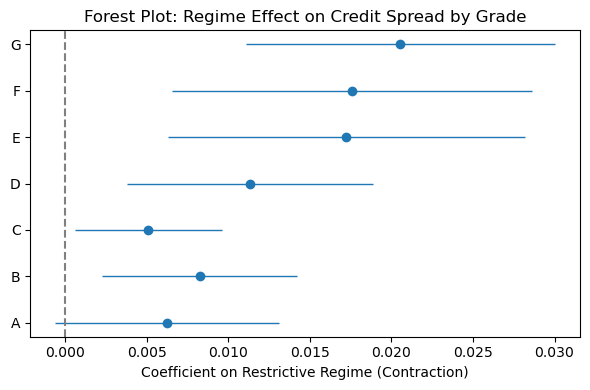

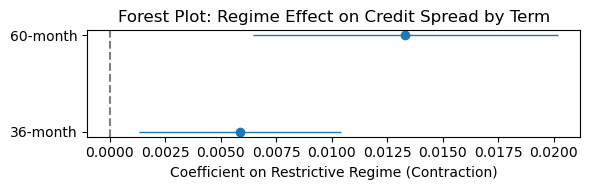

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Extract coefficient + 95% CI for the Contraction dummy across grades
rows = []
for grade, res in grade_results.items():
    coef = res.params['Contraction']
    lo, hi = res.conf_int().loc['Contraction']
    rows.append({'Grade': grade, 'coef': coef, 'ci_lo': lo, 'ci_hi': hi})

df_plot = pd.DataFrame(rows).sort_values('Grade')
y = np.arange(len(df_plot))

fig, ax = plt.subplots(figsize=(6,4))
ax.hlines(y, df_plot['ci_lo'], df_plot['ci_hi'], linewidth=1)
ax.plot(df_plot['coef'], y, 'o')
ax.axvline(0, color='grey', linestyle='--')
ax.set_yticks(y)
ax.set_yticklabels(df_plot['Grade'])
ax.set_xlabel('Coefficient on Restrictive Regime (Contraction)')
ax.set_title('Forest Plot: Regime Effect on Credit Spread by Grade')
plt.tight_layout()
plt.savefig("fig_forest_contraction_by_grade.png", dpi=300)
plt.show()

# --- Forest plot by Term ---
rows_t = []
for term, res in term_results.items():
    coef = res.params['Contraction']
    lo, hi = res.conf_int().loc['Contraction']
    rows_t.append({'Label': f"{int(term)}-month", 'coef': coef, 'ci_lo': lo, 'ci_hi': hi})

df_term = pd.DataFrame(rows_t).sort_values('Label')
y_term = np.arange(len(df_term))

fig, ax = plt.subplots(figsize=(6,2))
ax.hlines(y_term, df_term['ci_lo'], df_term['ci_hi'], linewidth=1)
ax.plot(df_term['coef'], y_term, 'o')
ax.axvline(0, color='grey', linestyle='--')
ax.set_yticks(y_term)
ax.set_yticklabels(df_term['Label'])
ax.set_xlabel('Coefficient on Restrictive Regime (Contraction)')
ax.set_title('Forest Plot: Regime Effect on Credit Spread by Term')
plt.tight_layout()
plt.savefig("fig_forest_contraction_by_term.png", dpi=300)
plt.show()


In [17]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

def wcb_t_multi(df, formula, cluster_col, targets, B=999, seed=42):
    """
    Wild cluster bootstrap-t for multiple target coefficients.
    Returns a DataFrame with beta_hat, cluster SE, observed t-stat,
    and bootstrap p-value for each target.
    """
    np.random.seed(seed)
    # Fit the unrestricted model once
    res = smf.ols(formula, data=df).fit()
    yhat = res.fittedvalues
    uhat = res.resid
    beta_hat = res.params[targets]
    t_obs = res.tvalues[targets]
    
    # Prepare cluster labels
    clusters = df[cluster_col].values
    cl_unique = pd.unique(clusters)
    
    # Initialize storage for bootstrap t-statistics
    t_stats = {t: [] for t in targets}
    
    # Bootstrap loop
    for _ in range(B):
        # Draw Rademacher weights per cluster
        w = pd.Series(
            np.random.choice([-1, 1], size=len(cl_unique)),
            index=cl_unique
        )
        # Construct bootstrap residuals and dependent variable
        u_star = uhat * w.loc[clusters].values
        y_star = yhat + u_star
        
        # Refit on the bootstrap sample
        res_b = smf.ols(formula.replace('credit_spread', 'y_star'), data=df.assign(y_star=y_star)).fit()
        
        # Compute t-stat for each target
        for t in targets:
            beta_b = res_b.params[t]
            se_b   = res_b.bse[t]
            t_stats[t].append((beta_b - beta_hat[t]) / se_b)
    
    # Compute bootstrap p-values
    p_wcb = {
        t: np.mean(np.abs(t_stats[t]) >= np.abs(t_obs[t]))
        for t in targets
    }
    
    # Assemble results
    return pd.DataFrame({
        'beta_hat':    beta_hat,
        'se_cluster':  res.bse[targets],
        't_obs':       t_obs,
        'p_wcb':       pd.Series(p_wcb)
    })

# Define your formulas (as before)
grade_formula = (
    "credit_spread ~ Contraction + "
    + " + ".join(top_feats)
    + " + term_num + dti + np.log(annual_inc)"
)
term_formula = (
    "credit_spread ~ Contraction + "
    + " + ".join(top_feats)
    + " + C(grade) + dti + np.log(annual_inc)"
)

# Set targets: Contraction plus the five macro drivers
targets = ['Contraction'] + top_feats

# A) Grade‑specific wild cluster bootstrap-t
print("=== Wild cluster bootstrap-t by Grade ===\n")
for grade in sorted(df_loans['grade'].dropna().unique()):
    df_g = (
        df_loans[df_loans['grade'] == grade]
        .dropna(subset=['credit_spread','term_num','dti','annual_inc','Contraction'] + top_feats)
    )
    print(f"Grade {grade}:")
    results_g = wcb_t_multi(df_g, grade_formula, cluster_col='ym', targets=targets, B=999, seed=42)
    print(results_g, "\n")

# B) Term‑specific wild cluster bootstrap-t
print("\n=== Wild cluster bootstrap-t by Term ===\n")
for term in sorted(df_loans['term_num'].dropna().unique()):
    df_t = (
        df_loans[df_loans['term_num'] == term]
        .dropna(subset=['credit_spread','dti','annual_inc','Contraction'] + top_feats)
    )
    print(f"Term {term}-month:")
    results_t = wcb_t_multi(df_t, term_formula, cluster_col='ym', targets=targets, B=999, seed=42)
    print(results_t, "\n")


=== Wild cluster bootstrap-t by Grade ===

Grade A:
             beta_hat  se_cluster      t_obs     p_wcb
Contraction  0.006250    0.000356  17.553173  0.050050
D023         0.035214    0.001029  34.215640  0.000000
D597        -0.002616    0.000096 -27.349707  0.003003
D084        -0.000431    0.000249  -1.729935  0.873874
D647        -0.044785    0.003991 -11.220950  0.295295
D646        -0.003699    0.001796  -2.059066  0.817818 

Grade B:
             beta_hat  se_cluster      t_obs     p_wcb
Contraction  0.008233    0.000356  23.153003  0.001001
D023         0.050766    0.001075  47.237887  0.000000
D597        -0.005545    0.000101 -54.804288  0.000000
D084        -0.001520    0.000273  -5.574511  0.751752
D647        -0.041812    0.004172 -10.022714  0.452452
D646        -0.031625    0.001991 -15.882197  0.249249 

Grade C:
             beta_hat  se_cluster      t_obs     p_wcb
Contraction  0.005099    0.000366  13.918811  0.022022
D023         0.048285    0.001103  43.764019  

In [24]:
# Run a two-step Fama-MacBeth decomposition as alternate model specification

# ---------- STEP 1 (centered controls): monthly cross-sections ----------
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
from collections import defaultdict

df = df_loans.dropna(subset=['credit_spread','grade','term_num','dti','annual_inc']).copy()
df['is60']  = (df['term_num']==60).astype(int)
df['lninc'] = np.log(df['annual_inc'])

coef_by_m, se_by_m, n_by_m = defaultdict(dict), defaultdict(dict), {}
for ym, g in df.groupby('ym'):
    # require adequate cross-sectional variation
    if g['grade'].nunique() < 3 or len(g) < 100:
        continue

    # center controls within the month
    g = g[['credit_spread','grade','is60','dti','lninc']].copy()
    g = g.replace([np.inf, -np.inf], np.nan).dropna()
    if g.empty or g['grade'].nunique() < 3 or len(g) < 100:
        continue
    g['dti_c']   = g['dti']   - g['dti'].mean()
    g['lninc_c'] = g['lninc'] - g['lninc'].mean()

    # OLS with centered controls; Intercept is "avg borrower" now
    res = smf.ols('credit_spread ~ is60 + dti_c + lninc_c + C(grade)', data=g).fit()
    for k, v in res.params.items():
        coef_by_m[ym][k] = v
    for k, v in res.bse.items():
        se_by_m[ym][k] = v
    n_by_m[ym] = len(g)

coef_panel = pd.DataFrame.from_dict(coef_by_m, orient='index').sort_index()
se_panel   = pd.DataFrame.from_dict(se_by_m,   orient='index').reindex_like(coef_panel)

INTERCEPT = 'Intercept' if 'Intercept' in coef_panel.columns else 'const'


In [25]:
# ---------- STEP 2: Time-series on monthly premia (HAC; optional precision weights) ----------
import re
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd

# 2.1 Build month-level driver panel Z
#      • Contraction dummy from decoded labels
#      • Try to locate smoothed posterior p(restrictive) in df_probs
Z = pd.DataFrame(index=coef_panel.index)

# Contraction (0/1)
if 'RegimeLabel' in df_probs.columns:
    Z['Contraction'] = (df_probs.loc[Z.index, 'RegimeLabel'] == 2).astype(int)
else:
    # Fallback: if you stored labels under a different name; adjust as needed
    raise KeyError("Cannot find 'RegimeLabel' in df_probs. Add/rename before Step 2.")

# Attempt to auto-detect a probability column for the restrictive state
prob_candidates = []
for c in df_probs.columns:
    c_norm = c.strip().lower()
    if any(k in c_norm for k in ['prob', 'p(', 'regime 1', 'regime 2', 'restrictive', 'state 1', 'state 2']):
        prob_candidates.append(c)

p_col = None
# Prefer explicit 'Regime 2' style names
for cname in prob_candidates:
    if re.search(r'(regime\s*2|p\(regime\s*2\)|restrictive|state\s*2)', cname, flags=re.I):
        s = df_probs[cname]
        # Accept only if it looks like a probability
        if s.min() >= -1e-6 and s.max() <= 1+1e-6 and s.std() > 0:
            p_col = cname
            break

# If not found, try any probability-like column that correlates with Contraction
if p_col is None:
    for cname in prob_candidates:
        s = df_probs[cname]
        if s.min() >= -1e-6 and s.max() <= 1+1e-6 and s.std() > 0:
            corr = s.loc[Z.index].corr(Z['Contraction'])
            if corr is not None and corr > 0.20:
                p_col = cname
                break

if p_col is not None:
    Z['p_restrictive'] = df_probs.loc[Z.index, p_col].clip(0, 1)
    print(f"[Step 2] Using posterior probability column for restrictive state: {p_col!r}")
else:
    # Fallback: if no probability column exists, proxy with the dummy (will replicate Contraction-only results)
    Z['p_restrictive'] = Z['Contraction'].astype(float)
    print("[Step 2] No probability column detected in df_probs; using Contraction dummy as proxy for p_restrictive.")

# Add continuous macro drivers from df_final (aligned by index)
for v in ['D023','D597','D646','D647','D084']:
    if v not in df_final.columns:
        raise KeyError(f"Macro series {v} not found in df_final.")
    Z[v] = df_final.loc[Z.index, v]

# Drop months with any missing drivers
Z = Z.dropna()

# 2.2 Join monthly cross-sectional premia (coef_panel) with drivers Z
TS = coef_panel.join(Z, how='inner')
SE = se_panel.reindex_like(coef_panel).loc[TS.index]

# Normalize intercept column name from Step 1
INTERCEPT = 'Intercept' if 'Intercept' in TS.columns else ('const' if 'const' in TS.columns else None)
if INTERCEPT is None:
    raise KeyError("Neither 'Intercept' nor 'const' found in coef_panel columns. Check Step 1 output.")

# 2.3 Helper to run HAC-WLS (precision-weighted by 1/SE^2 on the target coefficient)
def run_second_stage(target, rhs, weight_by_precision=True, hac_lags=3):
    cols_needed = [target] + rhs.replace(' ', '').split('+')
    cols_needed = [c for c in cols_needed if c]  # clean empties
    data = TS.dropna(subset=cols_needed).copy()
    if data.empty:
        raise ValueError(f"No overlapping rows for target={target} with RHS={rhs}.")

    if weight_by_precision:
        w = 1.0 / np.square(np.maximum(SE.loc[data.index, target].astype(float), 1e-6))
        data = data.assign(w=w)
        mod = smf.wls(f"{target} ~ {rhs}", data=data, weights=data['w'])
    else:
        mod = smf.ols(f"{target} ~ {rhs}", data=data)

    return mod.fit(cov_type='HAC', cov_kwds={'maxlags': hac_lags})

# 2.4 Define RHS strings for the four robustness variants
rhs_full   = "Contraction + D023 + D597 + D646 + D647 + D084"
rhs_contr  = "Contraction"
rhs_ponly  = "p_restrictive"
rhs_pfull  = "p_restrictive + D023 + D597 + D646 + D647 + D084"

# 2.5 Run for monthly pricing level (intercept) and the 60m maturity premium (is60) if present
targets = [INTERCEPT]
if 'is60' in TS.columns:
    targets.append('is60')

for tgt in targets:
    print(f"\n[FM] Second stage — FULL (Contraction + macros) — target={tgt}")
    print(run_second_stage(tgt, rhs_full).summary().tables[1])

    print(f"\n[FM] Second stage — Contraction only — target={tgt}")
    print(run_second_stage(tgt, rhs_contr).summary().tables[1])

    print(f"\n[FM] Second stage — p(restrictive) only — target={tgt}")
    print(run_second_stage(tgt, rhs_ponly).summary().tables[1])

    print(f"\n[FM] Second stage — p(restrictive) + macros — target={tgt}")
    print(run_second_stage(tgt, rhs_pfull).summary().tables[1])

[Step 2] No probability column detected in df_probs; using Contraction dummy as proxy for p_restrictive.

[FM] Second stage — FULL (Contraction + macros) — target=Intercept
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0664      0.003     19.529      0.000       0.060       0.073
Contraction     0.0105      0.005      2.044      0.041       0.000       0.021
D023            0.0356      0.007      4.894      0.000       0.021       0.050
D597           -0.0033      0.001     -2.839      0.005      -0.006      -0.001
D646            0.0119      0.020      0.604      0.546      -0.027       0.051
D647           -0.0413      0.037     -1.102      0.270      -0.115       0.032
D084           -0.0005      0.003     -0.166      0.868      -0.006       0.005

[FM] Second stage — Contraction only — target=Intercept
                  coef    std err          z      

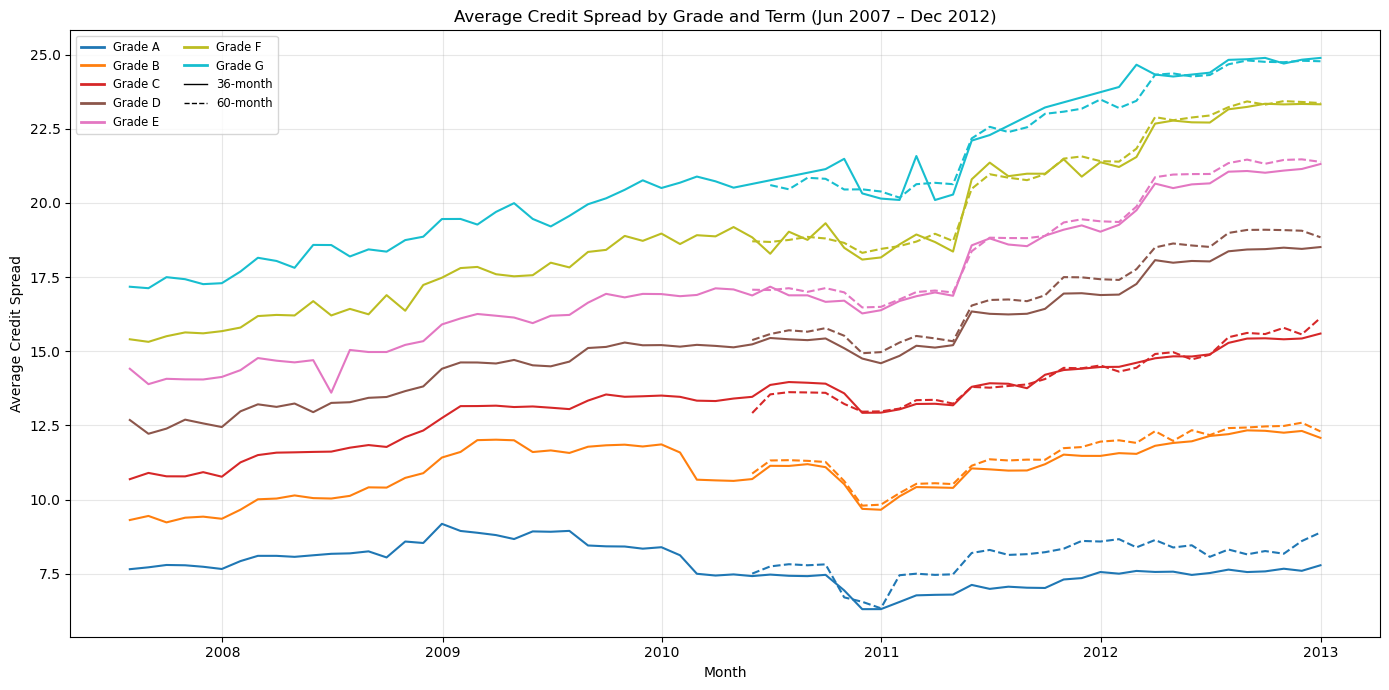

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from matplotlib.lines import Line2D

# ──────────────────────────────────────────────────────────────────────────────
# 1) Reload raw loans CSV and parse dates
# ──────────────────────────────────────────────────────────────────────────────
df_loans_raw = pd.read_csv("accepted_2007_to_2018Q4.csv", low_memory=False)
df_loans_raw.rename(columns={"issue_d": "issue_date"}, inplace=True)
df_loans_raw["issue_date"] = pd.to_datetime(
    df_loans_raw["issue_date"], format="%b-%Y"
)

# ──────────────────────────────────────────────────────────────────────────────
# 2) Filter to June 2007 – December 2012
# ──────────────────────────────────────────────────────────────────────────────
mask = (
    (df_loans_raw["issue_date"] >= "2007-06-01") &
    (df_loans_raw["issue_date"] <= "2012-12-31")
)
df_period = df_loans_raw.loc[mask].copy()

# ──────────────────────────────────────────────────────────────────────────────
# 3) Fetch 3‑ and 5‑year Treasury yields and prepare for asof‑merge
# ──────────────────────────────────────────────────────────────────────────────
start, end = df_period["issue_date"].min(), df_period["issue_date"].max()
yields = (
    pdr.DataReader(["DGS3", "DGS5"], "fred", start, end)
       .div(100)              # percent → decimal
       .resample("M").last()  # month‑end
)
# capture whatever the index name is (often "DATE")
idx_name = yields.index.name or "index"
yields_reset = (
    yields
      .reset_index()
      .rename(columns={
          idx_name:   "Date",
          "DGS3":     "RF_3yr",
          "DGS5":     "RF_5yr"
      })
      .sort_values("Date")
)

# ──────────────────────────────────────────────────────────────────────────────
# 4) Merge yields into loans by asof on issue_date
# ──────────────────────────────────────────────────────────────────────────────
df_plot = pd.merge_asof(
    df_period.sort_values("issue_date"),
    yields_reset,
    left_on="issue_date",
    right_on="Date",
    direction="backward"
)

# ──────────────────────────────────────────────────────────────────────────────
# 5) Compute matched risk‑free rate and credit spread
# ──────────────────────────────────────────────────────────────────────────────
# parse term_num if needed
if df_plot["term"].dtype == object:
    df_plot["term_num"] = df_plot["term"].str.extract(r"(\d+)").astype(int)

# ensure int_rate is decimal
if df_plot["int_rate"].dtype == object:
    df_plot["int_rate"] = (
        df_plot["int_rate"].str.rstrip("%").astype(float) / 100
    )

df_plot["RF_match"] = np.where(
    df_plot["term_num"] == 36,
    df_plot["RF_3yr"],
    df_plot["RF_5yr"]
)
df_plot["credit_spread"] = df_plot["int_rate"] - df_plot["RF_match"]

# ──────────────────────────────────────────────────────────────────────────────
# 6) Aggregate to monthly average spread by grade & term
# ──────────────────────────────────────────────────────────────────────────────
df_plot["ym"] = df_plot["issue_date"].dt.to_period("M").dt.to_timestamp("M")
grouped = (
    df_plot
    .groupby(["ym", "grade", "term_num"], as_index=False)["credit_spread"]
    .mean()
    .rename(columns={"credit_spread": "avg_spread"})
)
pivot = (
    grouped
    .pivot_table(index="ym", columns=["grade", "term_num"], values="avg_spread")
    .interpolate(method="time")
)

# ──────────────────────────────────────────────────────────────────────────────
# 7) Plot
# ──────────────────────────────────────────────────────────────────────────────
line_styles = {36: "-", 60: "--"}
grades = sorted(df_plot["grade"].dropna().unique())
cmap = plt.cm.get_cmap("tab10", len(grades))
grade_colors = {g: cmap(i) for i, g in enumerate(grades)}

fig, ax = plt.subplots(figsize=(14, 7))
for (grade, term), series in pivot.items():
    ax.plot(
        series.index,
        series.values,
        color=grade_colors[grade],
        linestyle=line_styles.get(term, "-"),
        label=f"Grade {grade} ({term}m)"
    )

# build legend
legend_elems = [
    Line2D([0], [0], color=grade_colors[g], lw=2, label=f"Grade {g}")
    for g in grades
] + [
    Line2D([0], [0], color="k", lw=1, linestyle="-",  label="36‑month"),
    Line2D([0], [0], color="k", lw=1, linestyle="--", label="60‑month"),
]
ax.legend(handles=legend_elems, ncol=2, fontsize="small", frameon=True)

ax.set_xlabel("Month")
ax.set_ylabel("Average Credit Spread")
ax.set_title("Average Credit Spread by Grade and Term (Jun 2007 – Dec 2012)")
ax.grid(alpha=0.3)
fig.tight_layout()
plt.show()

In [ ]:
# ---------------------------------------------------
# Save the *entire* workspace, including df_loans
# ---------------------------------------------------
#import dill, os, time

#SAVE_FILE = "irfa_workspace_full_v004.pkl"   # give it a clear name
#t0 = time.time()

#dill.dump_session(SAVE_FILE)            # ❶ nothing is dropped
#print(f"✓ session saved → {os.path.abspath(SAVE_FILE)}")
#print(f"  size ≈ {os.path.getsize(SAVE_FILE)/1_048_576:.1f} MB  "
#      f"time = {time.time()-t0:.1f}s")



✓ session saved → /Users/bal8/Desktop/Columbia SBA and Moodys Data/irfa_workspace_full_v004.pkl
  size ≈ 3395.1 MB  time = 94.3s
